# Comparison of "Full" Gradient Descent and Block Coordinate Gradient Descent methods

## Introduction

Following we will compare different gradient descent methods and BCGD methods using Gauss-Seidel scheme

The following are env variables used to control the behavior of the notebook:
 - `NUM_ITERS`: maximum number of iteration allowed to the algorithms
 - `NUM_POINTS`: number of points to generate
 - `OUTPUT_STEP`: controls the verbosity (`0.05` means _each 5% of the algorithm print update_)
 - `LABELED_PERCENTAGE`: percentage of points that are going to be labeled
 - `OPTIMIZE_RANDOM`: Nesterov improvement for the random BCGD method
 - `STEP_SIZE`: step size to use in case `USE_LIPSCHITZ_CONSTANT` is false
 - `EPSILON`: threshold of $||\nabla f(y)||$ to consider a solution as optimal/acceptable (in case of strong convexity, $f(x_k) - f(x^*) <= \epsilon^2/(4\sigma)$)
 - `USE_LIPSCHITZ_CONSTANT`: use Lipschitz constant for the step size (however to estimate it, it's necessary to calculate the eigenvalues of the Hessian, which for $\ge10.000$ point might take a while)
 - `OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM`: use the optimized Lipschitz constant for BCGM algorithms, calculatend on the block and not on the whole function (`USE_LIPSCHITZ_CONSTANT` must be true)
 - `INITIALIZE_RANDOM`: initialize unlabeled points in $\{-1, 1\}$, if `False` all points are initialized to 0
 - `PLOT_DPI`: DPI for the `matplotlib` plots
 - `FROM_DATASET`: if true, the dataset chosen on `DATASET` will be used, otherwise will use a a synthetic one
 - `DATASET`: from which dataset we want the data, available are:
   - `diabetes`: [Harvard Dataverse, Ramachandran, Anil, 2018](https://doi.org/10.7910/DVN/LRNLZV/ZIOATY)
   - `beans`: [KOKLU, M. and OZKAN, I.A., (2020), Multiclass Classification of Dry Beans](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset)
   - `mnist`: [MNIST digits from Sklearn](http://yann.lecun.com/exdb/mnist/)
   - `spiral`: spiral shaped syntetic dataset
 - `CREATE_GIF`: if true, at each iteration of every algorithm, will generate 3 images representing the current unlabeled configuration as binary and scaled, and the loss, and at the end from those images will generate gif inside the `gif` folder, which can then be seen in the HTML file in the current folder

In [169]:
NUM_ITERS = 50
NUM_POINTS = 7000
OUTPUT_STEP = 0.1
LABELED_PERCENTAGE = 0.01
OPTIMIZE_RANDOM = False
STEP_SIZE = 1e-2
EPSILON = 1e-11
USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
INITIALIZE_RANDOM = False
PLOT_DPI=150
FROM_DATASET = True
DATASET = "spiral"
CREATE_GIF = False

In [170]:
import math
import matplotlib.pyplot as pl
import random
import numpy as np
import scipy.linalg
import time
from sklearn.metrics.pairwise import euclidean_distances
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tensorflow import keras
import pandas as pd
from io import StringIO
import os
import imageio
from os import walk
import shutil

Setting seed in order to have reproducible results

In [171]:
random.seed(1)
np.random.seed(1)

In [172]:
# helper to delete all file in folder to prepare folders for gifs
def delete_files_in_folder(dirpath):
    for filename in os.listdir(dirpath):
        filepath = os.path.join(dirpath, filename)
        try:
            shutil.rmtree(filepath)
        except OSError:
            os.remove(filepath)
# helper to create folder to prepare for gifs
def check_or_create(path):
    exist = os.path.exists(path)
    if not exist:
        os.makedirs(path)

def create_frame_points_scale(i, x_unlabeled, y_unlabeled, path, title="Plot"):
    fig = pl.figure(dpi=PLOT_DPI)
    pl.title(f"{title} - iteration {i}")
    pl.scatter(x_unlabeled[:,0], x_unlabeled[:,1], c=y_unlabeled)
    pl.colorbar()
    pl.plot()
    pl.savefig(f'{path}frame-{i:05}.png')
    pl.close(fig)

def create_frame_points_binary(i, x_unlabeled, y_unlabeled, path, title="Plot"):
    fig = pl.figure(dpi=PLOT_DPI)
    pl.title(f"{title} - iteration {i}")
    pl.scatter(x_unlabeled[y_unlabeled > 0][:,0], x_unlabeled[y_unlabeled > 0][:,1])
    pl.scatter(x_unlabeled[y_unlabeled <= 0][:,0], x_unlabeled[y_unlabeled <= 0][:,1])
    pl.plot()
    pl.savefig(f'{path}frame-{i:05}.png')
    pl.close(fig)

def create_frame_loss(i, loss, path, title="Plot"):
    fig = pl.figure(dpi=PLOT_DPI)
    pl.title(f"Loss {title} - iteration {i}")
    pl.plot(loss)
    pl.savefig(f'{path}loss-frame-{i:05}.png')
    pl.close(fig)

### Generating points

Depending if `FROM_DATASET` is `True`, the dataset elements will be decomposed using PCA, since the model is very sensible to curse of dimensionality.

In [173]:
if FROM_DATASET and DATASET == "diabetes":
    CLASS_0 = "https://drive.google.com/uc?export=download&id=1GAsdQfu3VfIE9HdjMmNssD0LUpNZC9oq"
    CLASS_1 = "https://drive.google.com/uc?export=download&id=1wDnGDGAgzGV_20AocaW4icCpgtP2vZzZ"

    print("""
    Downloading dataset:
    Ramachandran, Anil, 2018, "class0_diabetes.txt", Binary dataset, https://doi.org/10.7910/DVN/LRNLZV/ZIOATY, Harvard Dataverse, V1
    """)
    r0 = [[float(s) for s in row.split('\t')][:-1]
          for row in requests.get(CLASS_0, allow_redirects=True).content.decode("utf-8").replace("\r", "").split("\n")[:-1]]
    tuples_0 = np.array(r0).astype('float64')
    print("""
    Downloading dataset:
    Ramachandran, Anil, 2018, "class1_diabetes.txt", Binary dataset, https://doi.org/10.7910/DVN/LRNLZV/0KQIC4, Harvard Dataverse, V1
    """)
    r1 = [[float(s) for s in row.split('\t')][:-1]
          for row in requests.get(CLASS_1, allow_redirects=True).content.decode("utf-8").replace("\r", "").split("\n")[:-1]]
    tuples_1 = np.array(r1).astype('float64')

    pca = PCA(n_components=2).fit(np.concatenate((tuples_0, tuples_1)))
    tuples_0 = pca.transform(tuples_0)
    tuples_1 = pca.transform(tuples_1)

    points = min(len(tuples_0), len(tuples_1), NUM_POINTS)
    tuples_0 = tuples_0[:points]
    tuples_1 = tuples_1[:points]
    print("Done")

elif FROM_DATASET and DATASET == "mnist":
    print("Loading mnist digits 28x28")
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
    X = X.reshape((X.shape[0], -1))

    pca = PCA(n_components=5)
    X = pca.fit_transform(X)

    points = min(np.sum(Y == 0), np.sum(Y != 0), NUM_POINTS)
    tuples_0 = X[Y == 0][:points]
    tuples_1 = X[Y != 0][:points]
    print("Done")

elif FROM_DATASET and DATASET == "beans":
    print("""
    Downloading dataset:
    KOKLU, M. and OZKAN, I.A., (2020), Multiclass Classification of Dry Beans Using Computer Vision and Machine Learning Techniques. Computers and Electronics in Agriculture, 174, 105507.
    """)
    URL = "https://drive.google.com/uc?export=download&id=1UOrXMy6uKDhnwS9fAyFmSjtpxFkyh8Zg"
    # we are just going to use "SIRA" (2636 samples) vs "DERMASON" (3546 samples)
    data_raw = StringIO(requests.get(URL, allow_redirects=True).content.decode("utf-8"))
    df = pd.read_csv(data_raw, delimiter=";", header=None)
    target = df[16].to_numpy()
    data = df.drop(16, axis=1).to_numpy(dtype="float64")

    pca = PCA(n_components=5)
    data = pca.fit_transform(data)

    points = min(np.sum(target == "SIRA"), np.sum(target == "DERMASON"), NUM_POINTS)
    tuples_0 = data[target == "SIRA"][:points]
    tuples_1 = data[target != "DERMASON"][:points]
    print("Done")
elif FROM_DATASET and DATASET == "spiral":
    theta = np.sqrt(np.random.rand(NUM_POINTS))*4*np.pi # np.linspace(0,2*pi,100)

    r_a = 2*theta + np.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    tuples_0 = data_a + np.random.randn(NUM_POINTS,2)

    r_b = -2*theta - np.pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    tuples_1 = data_b + np.random.randn(NUM_POINTS,2)

Following, commented, are some possible "nice" generator of points to use in case `FROM_DATASET` is `false`

In [174]:
"""gen1 = lambda x : -pow(x-.45, 5) * 20 + 0.8
gen2 = lambda x : -pow(x-.3, 2) * 5 + 0.4
range1 = (0, 1)
range2 = (0, 1)"""

"""gen1 = lambda x : math.e**(-x+2)+1
gen2 = lambda x : -math.e**(x-5)+6
range1 = (1, 6)
range2 = (1, 6)"""


"""gen1 = lambda x: ((2*x-1.5) ** 3 + (2*x-1.5) ** 2 + 0.3)/2
gen2 = lambda x: x**2/5 + 0.5
range1 = (0, 1)
range2 = (0, 1)"""

"""
gen1 = lambda x : x
gen2 = lambda x : -x
range1 = (-1, 1)
range2 = (-1, 1)
"""

gen1 = lambda x : x+.5
gen2 = lambda x : x-.5
gen3 = lambda x : -x+.5
gen4 = lambda x : -x-.5
range1 = (-1, 1)
range2 = (-1, 1)






In [175]:
if not FROM_DATASET:
    print("Generating points")
    # to create cross using gen{1,2,3,4}
    x0 = np.random.uniform(*range1, NUM_POINTS//4)
    x1 = np.random.uniform(*range2, NUM_POINTS//4)
    perm = np.random.permutation(NUM_POINTS//2)
    f_x0 = np.concatenate((gen1(x0), gen2(x0)))[perm]
    f_x1 = np.concatenate((gen3(x1), gen4(x1)))[perm]
    x0 = np.concatenate((x0,x0))[perm]
    x1 = np.concatenate((x1,x1))[perm]

    #otherwise
    """x0 = np.random.uniform(*range1, NUM_POINTS//2)
    x1 = np.random.uniform(*range2, NUM_POINTS//2)
    f_x0 = gen1(x0)
    f_x1 = gen2(x1)"""
    print("done")

    pl.figure(dpi=PLOT_DPI)
    pl.title("Points without noise")
    pl.scatter(x0, f_x0)
    pl.scatter(x1, f_x1)
    pl.legend(["Class -1","Class 1"])

    print("Generating variances")
    rand_var_0 = np.random.normal(0, 0.1, len(x0))
    rand_var_1 = np.random.normal(0, 0.1, len(x1))

    f_x0_final = f_x0 + rand_var_0
    f_x1_final = f_x1 + rand_var_1
    print("Done")

    pl.figure(dpi=PLOT_DPI)
    pl.axis('auto')
    pl.scatter(x0, f_x0_final)
    pl.title("Points with noise")
    pl.scatter(x1, f_x1_final)
    pl.legend(["Class -1","Class 1"])

    tuples_0 = np.array(list(zip(x0, f_x0_final)))
    tuples_1 = np.array(list(zip(x1, f_x1_final)))


In [176]:
print("Splitting points in labeled and unlabeled")
print(f"{len(tuples_0)} elements class -1 and {len(tuples_1)} elements class 1")
scaler = pipe = Pipeline([('mm_scaler', MinMaxScaler()),('std_scaler', StandardScaler())]).fit(np.concatenate((tuples_0, tuples_1)))
# unlabeled examples of class -1
x_0 = scaler.transform(tuples_0[int(len(tuples_0) * LABELED_PERCENTAGE):])
# labeled examples of class -1
x_bar_0 = scaler.transform(tuples_0[:int(len(tuples_0) * LABELED_PERCENTAGE)])
# label for unlabeled examples of class -1
y_0 = np.repeat(-1, len(x_0)).astype('float64')
# label for labeled examples of class -1
y_bar_0 = np.repeat(-1, len(x_bar_0)).astype('float64')

# unlabeled examples of class 1
x_1 = scaler.transform(tuples_1[int(len(tuples_1) * LABELED_PERCENTAGE):])
# labeled examples of class 1
x_bar_1 = scaler.transform(tuples_1[:int(len(tuples_1) * LABELED_PERCENTAGE)])
# label for unlabeled examples of class 1
y_1 = np.repeat(1, len(x_1)).astype('float64')
# label for labeled examples of class 1
y_bar_1 = np.repeat(1, len(x_bar_1)).astype('float64')

x_unlabeled = np.concatenate((x_0, x_1))
x_labeled = np.concatenate((x_bar_0, x_bar_1))
y_labeled = np.concatenate((y_bar_0, y_bar_1))
y_unlabeled_target = np.concatenate((y_0, y_1))

# we need to optimize this one
y_unlabeled_initial = np.random.choice([-1, 1], size=(len(x_unlabeled),)) \
    if INITIALIZE_RANDOM else np.array([0], dtype='float64').repeat(len(x_unlabeled))
print(f"{len(x_labeled)} elements labeled and {len(x_unlabeled)} elements unlabeled")
print("Done")

Splitting points in labeled and unlabeled
7000 elements class -1 and 7000 elements class 1
140 elements labeled and 13860 elements unlabeled
Done


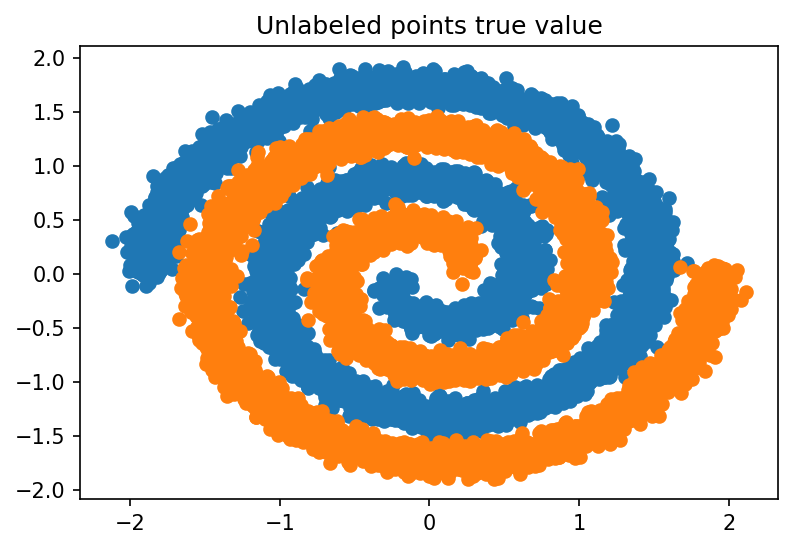

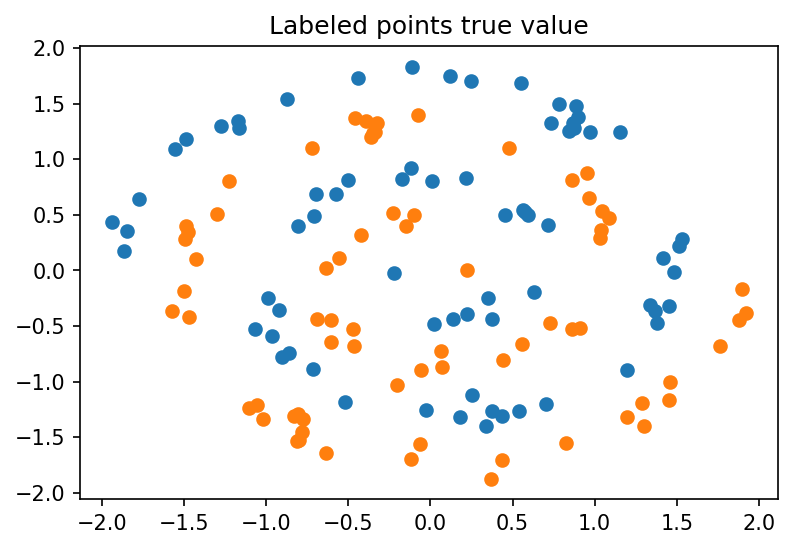

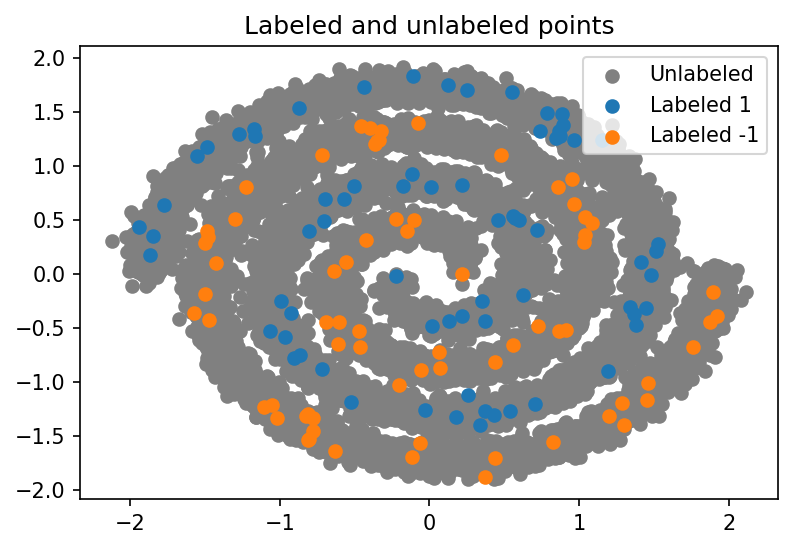

In [177]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    if INITIALIZE_RANDOM:
        colors = np.repeat("#1f77b4", len(y_unlabeled_initial))
        colors[y_unlabeled_initial == 1] = '#ff7f0e'
        pl.figure(dpi=PLOT_DPI)
        pl.title("Unlabeled points initalization")
        pl.scatter(x_unlabeled[:,0], x_unlabeled[:,1], c=colors)
        pl.show()

    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points true value")
    pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]])
    pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]])
    pl.show()


    pl.figure(dpi=PLOT_DPI)
    pl.title("Labeled points true value")
    pl.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]])
    pl.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]])
    pl.show()

    pl.figure(dpi=PLOT_DPI)
    pl.title("Labeled and unlabeled points")
    pl.scatter([p[0] for p in x_unlabeled], [p[1] for p in x_unlabeled], c="grey")
    pl.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]])
    pl.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]])
    pl.legend(["Unlabeled", "Labeled 1", "Labeled -1"])
    pl.show()

In [178]:
#This is used only in case we want the GIF to be generated to create or clear folders
if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
    check_or_create("./gif")
    paths =[
        "./gif/gd",
        "./gif/gd_exact",
        "./gif/gd_improved",
        "./gif/gd_hb",
        "./gif/gd_accelerated",
        "./gif/bcgd_random",
        "./gif/bcgd_cyclic",
        "./gif/bcgd_gs",
        "./gif/bcgd_gs_exact",

        "./gif/gd_binary",
        "./gif/gd_exact_binary",
        "./gif/gd_improved_binary",
        "./gif/gd_hb_binary",
        "./gif/gd_accelerated_binary",
        "./gif/bcgd_random_binary",
        "./gif/bcgd_cyclic_binary",
        "./gif/bcgd_gs_binary",
        "./gif/bcgd_gs_exact_binary",

        "./gif/loss_gd",
        "./gif/loss_gd_exact",
        "./gif/loss_gd_improved",
        "./gif/loss_gd_hb",
        "./gif/loss_gd_accelerated",
        "./gif/loss_bcgd_random",
        "./gif/loss_bcgd_cyclic",
        "./gif/loss_bcgd_gs",
        "./gif/loss_bcgd_gs_exact",
    ]
    for path in paths:
        check_or_create(path)
        delete_files_in_folder(path)

### Calculating weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-C ||a-b||^2_2}
$$

In [179]:
def weight(dist):
    return math.e**(-250* dist**2)

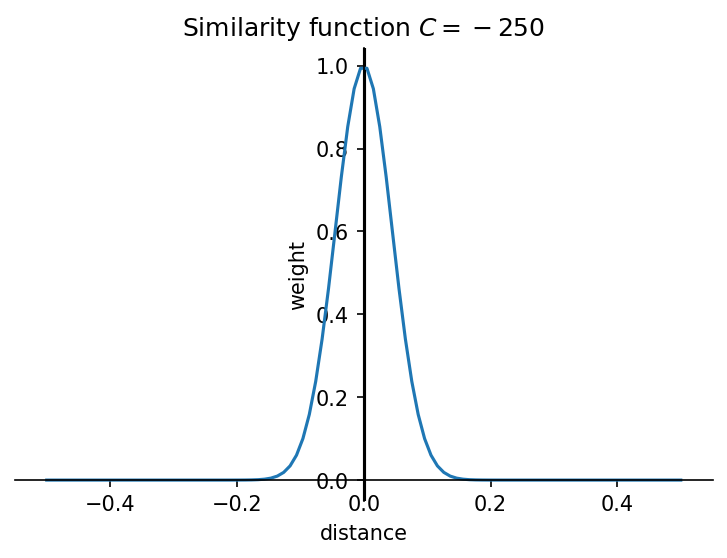

In [180]:
X = np.linspace(-.5, .5, 100)
pl.figure(dpi=PLOT_DPI)
pl.title("Similarity function $C=-250$")
ax = pl.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X])


In [181]:
%%time
def weights_labeled_unlabeled():
    labeled_unlabeled = euclidean_distances(x_labeled, x_unlabeled) / x_labeled.shape[1]
    return weight(labeled_unlabeled)

print("Calculating weights between labeled points and unlabeled points")
w_labeled_unlabeled = weights_labeled_unlabeled()
print("Done")

Calculating weights between labeled points and unlabeled points
Done
CPU times: user 155 ms, sys: 193 ms, total: 349 ms
Wall time: 41 ms


In [182]:
%%time
def weights_unlabeled_unlabeled():
    unlabeled_unlabeled = euclidean_distances(x_unlabeled, x_unlabeled) / x_unlabeled.shape[1]
    return weight(unlabeled_unlabeled)

print("Calculating weights between unlabeled points and unlabeled points")
w_unlabeled_unlabeled = weights_unlabeled_unlabeled()
print("Done")

Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 3.15 s, sys: 2.71 s, total: 5.86 s
Wall time: 3.44 s


The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the fist one is the iterative and naive implementation, the second one is using linear algebra and Numpy to calcolate it, in order to have decent performance

### Loss and Accuracy

In [183]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w_labeled_unlabeled.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_unlabeled_unlabeled.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2


The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [184]:
# accuracy score, rounding current to {-1,1} and comparing with target
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)

# accuracy from a loss point of view, however it has the problem that
# the minimum of the loss might be greater than 0
max_loss = np.sum(w_labeled_unlabeled) * 4 + np.sum(w_unlabeled_unlabeled) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

# accuracy from a target point of view, aka distance from current to target
initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=1)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=1)
    return 1 - current_distance / initial_distance

# the accuracy used as proxy to switch from one to another
def accuracy(current):
    return accuracy_norm(current)

### Hessian and constants

Those functions are used to calculate the Hessian matrix and the Lipschitz constant for the whole problem and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=-2\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2[(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj}] \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  2\cdot\left[ {\begin{array}{cccc}
    (\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & (\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & (\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$

In [185]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat * 2

def estimate_lipschitz_constant(hessian):
    # max eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

def estimate_degree_strongly_convex(hessian):
    # min eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 1.469514551609982,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 253.49838753535576
Estimating Lipschitz constant for each single variable
Done
CPU times: user 19min 22s, sys: 54.6 s, total: 20min 17s
Wall time: 2min 32s


## Gradient Descent Methods

Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [186]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(w_labeled_unlabeled, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(w_unlabeled_unlabeled, axis=0).reshape((-1,1))
grad_first_coeff_vec = (sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = np.multiply(
    y_labeled.reshape((-1,1)),
    w_labeled_unlabeled
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + 2 \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = 2 * (\sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - 2\sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [187]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.dot(w_unlabeled_unlabeled.T, unlabeled)
    return 2 * (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [188]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [189]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
        create_frame_points_scale(i, x_unlabeled, y_unlabeled_gd, "./gif/gd/", "Gradient Descent")
        create_frame_points_binary(i, x_unlabeled, y_unlabeled_gd, "./gif/gd_binary/", "Gradient Descent")
        create_frame_loss(i, losses_gd, "./gif/loss_gd/", "Gradient Descent")

    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 50 - final accuracy 00.62% - loss 10844.57
10% - iter 5 / 50 - final accuracy 03.56% - loss 9968.76
20% - iter 10 / 50 - final accuracy 06.26% - loss 9327.64
30% - iter 15 / 50 - final accuracy 08.75% - loss 8818.74
40% - iter 20 / 50 - final accuracy 11.06% - loss 8401.90
50% - iter 25 / 50 - final accuracy 13.19% - loss 8053.94
60% - iter 30 / 50 - final accuracy 15.17% - loss 7759.68
70% - iter 35 / 50 - final accuracy 17.01% - loss 7508.40
80% - iter 40 / 50 - final accuracy 18.72% - loss 7292.22
90% - iter 45 / 50 - final accuracy 20.32% - loss 7105.14

Final accuracy: 21.51%
Norm gradient: 88.6320388666827
Loss: 6973.220099859146

CPU times: user 2min 29s, sys: 2min, total: 4min 29s
Wall time: 2min 27s


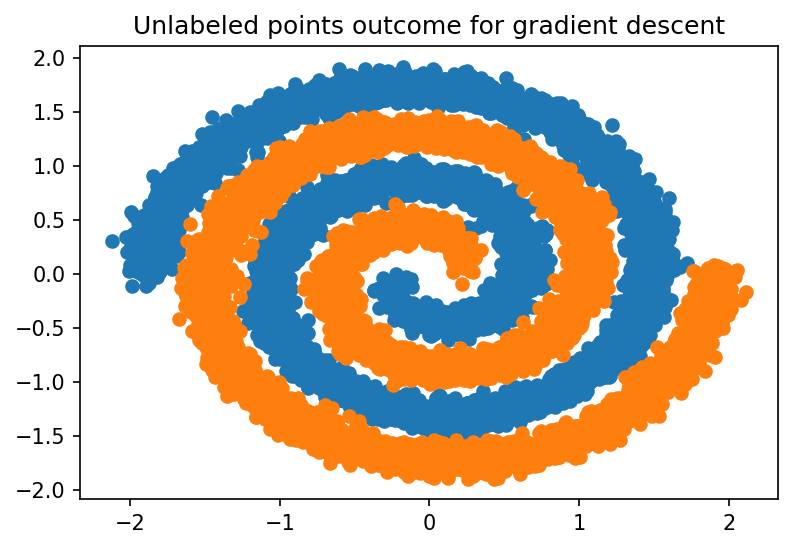

In [190]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for gradient descent")
    final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

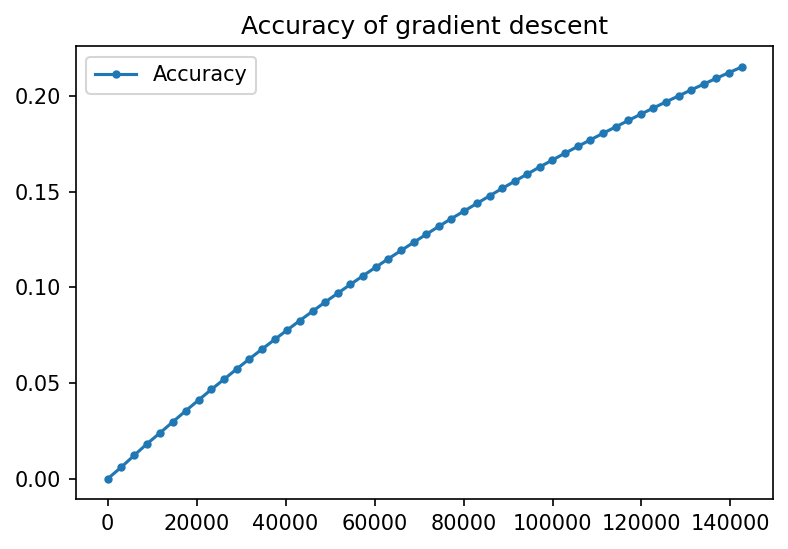

In [191]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of gradient descent")
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.legend(["Accuracy"])

### Gradient Descent with exact line search

In [192]:
y_unlabeled_gd_exact = np.copy(y_unlabeled_initial)

In [193]:
def calculate_exact_step(d, y_unlabeled):
    global y_labeled
    y_labeled = y_labeled.reshape((-1, 1))
    y_unlabeled = y_unlabeled.reshape((-1, 1))
    mat_d = d.reshape((-1,1)) - d.reshape((-1,1)).T
    top_first = 2 * np.multiply(y_unlabeled - y_labeled.T, np.multiply(w_labeled_unlabeled, d).T).sum()
    top_second = np.multiply(y_unlabeled - y_unlabeled.T, np.multiply(w_unlabeled_unlabeled, mat_d)).sum()

    bottom_first = 2 * np.multiply(w_labeled_unlabeled, d**2).sum()
    bottom_second = np.multiply(w_unlabeled_unlabeled, mat_d**2).sum()

    return - (top_first + top_second)/(bottom_first + bottom_second)

In [194]:
%%time
ticks_gd_exact = [0]
accuracies_gd_exact = [accuracy(y_unlabeled_gd_exact)]
losses_gd_exact = [loss(y_labeled, y_unlabeled_gd_exact)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
        create_frame_points_scale(i, x_unlabeled, y_unlabeled_gd_exact, "./gif/gd_exact/", "Gradient Descent with exact line search")
        create_frame_points_binary(i, x_unlabeled, y_unlabeled_gd_exact, "./gif/gd_exact_binary/", "Gradient Descent with exact line search")
        create_frame_loss(i, losses_gd_exact, "./gif/loss_gd_exact/", "Gradient Descent with exact line search")

    start = time.process_time()
    grad = gradient(y_unlabeled_gd_exact)

    if EPSILON >= np.linalg.norm(grad):
        break

    alpha = calculate_exact_step(grad, y_unlabeled_gd_exact)
    y_unlabeled_gd_exact = y_unlabeled_gd_exact + alpha * grad
    accuracies_gd_exact.append(accuracy(y_unlabeled_gd_exact))
    losses_gd_exact.append(loss(y_labeled, y_unlabeled_gd_exact))
    ticks_gd_exact.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_exact[-1])*100:05.2f}% - loss {losses_gd_exact[-1]:05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_exact[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_exact))}
Loss: {loss(y_labeled, y_unlabeled_gd_exact)}
""")

00% - iter 0 / 50 - final accuracy 06.56% - loss 9746.90
10% - iter 5 / 50 - final accuracy 12.15% - loss 8237.80
20% - iter 10 / 50 - final accuracy 16.48% - loss 7607.11
30% - iter 15 / 50 - final accuracy 19.93% - loss 7164.17
40% - iter 20 / 50 - final accuracy 23.01% - loss 6837.08
50% - iter 25 / 50 - final accuracy 25.54% - loss 6589.69
60% - iter 30 / 50 - final accuracy 27.85% - loss 6399.66
70% - iter 35 / 50 - final accuracy 29.77% - loss 6251.94
80% - iter 40 / 50 - final accuracy 31.52% - loss 6135.97
90% - iter 45 / 50 - final accuracy 32.99% - loss 6044.14

Final accuracy: 34.06%
Norm gradient: 55.06093296122271
Loss: 5984.239742228947

CPU times: user 2min 53s, sys: 2min 43s, total: 5min 37s
Wall time: 3min 34s


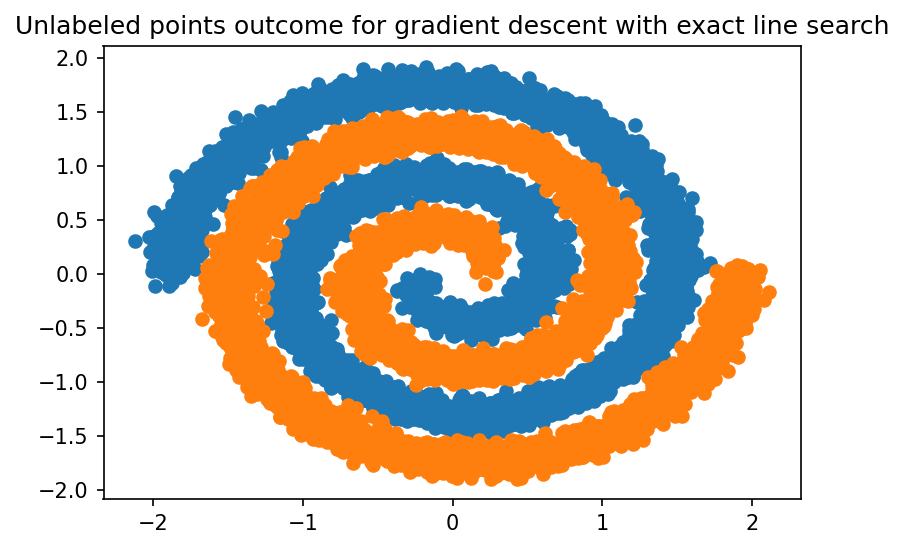

In [195]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for gradient descent with exact line search")
    final_y_unlabeled = (y_unlabeled_gd_exact/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

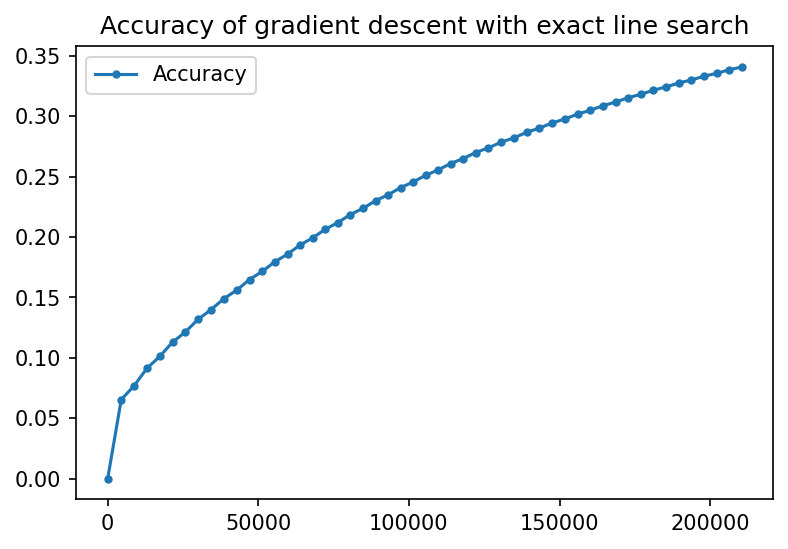

In [196]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of gradient descent with exact line search")
pl.plot(ticks_gd_exact, accuracies_gd_exact, marker='.')
pl.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm withh use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [197]:
y_unlabeled_gd_improved = np.copy(y_unlabeled_initial)

In [198]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(y_labeled, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
        create_frame_points_scale(i, x_unlabeled, y_unlabeled_gd_improved, "./gif/gd_improved/", "Gradient Descent Improved Rate")
        create_frame_points_binary(i, x_unlabeled, y_unlabeled_gd_improved, "./gif/gd_improved_binary/", "Gradient Descent Improved Rate")
        create_frame_loss(i, losses_gd_improved, "./gif/loss_gd_improved/", "Gradient Descent Improved Rate")


    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(y_labeled, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(y_labeled, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 50 - final accuracy 01.23% - loss 10629.54
10% - iter 5 / 50 - final accuracy 06.79% - loss 9209.99
20% - iter 10 / 50 - final accuracy 11.51% - loss 8322.36
30% - iter 15 / 50 - final accuracy 15.57% - loss 7702.85
40% - iter 20 / 50 - final accuracy 19.07% - loss 7250.37
50% - iter 25 / 50 - final accuracy 22.10% - loss 6911.02
60% - iter 30 / 50 - final accuracy 24.75% - loss 6651.99
70% - iter 35 / 50 - final accuracy 27.06% - loss 6451.72
80% - iter 40 / 50 - final accuracy 29.08% - loss 6295.29
90% - iter 45 / 50 - final accuracy 30.85% - loss 6172.04

Final accuracy: 32.11%
Norm gradient: 47.96264692775366
Loss: 6092.012717060275

CPU times: user 2min 50s, sys: 2min 5s, total: 4min 55s
Wall time: 2min 52s


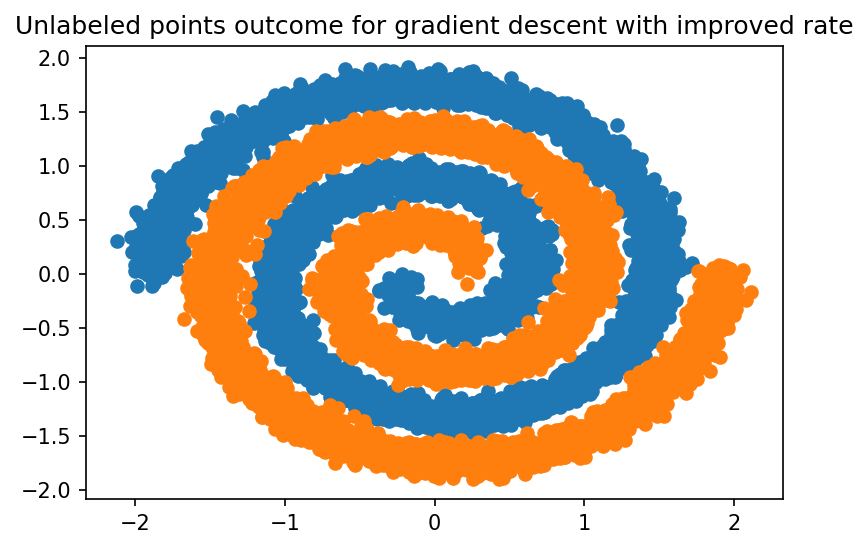

In [199]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for gradient descent with improved rate")
    final_y_unlabeled = (y_unlabeled_gd_improved/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

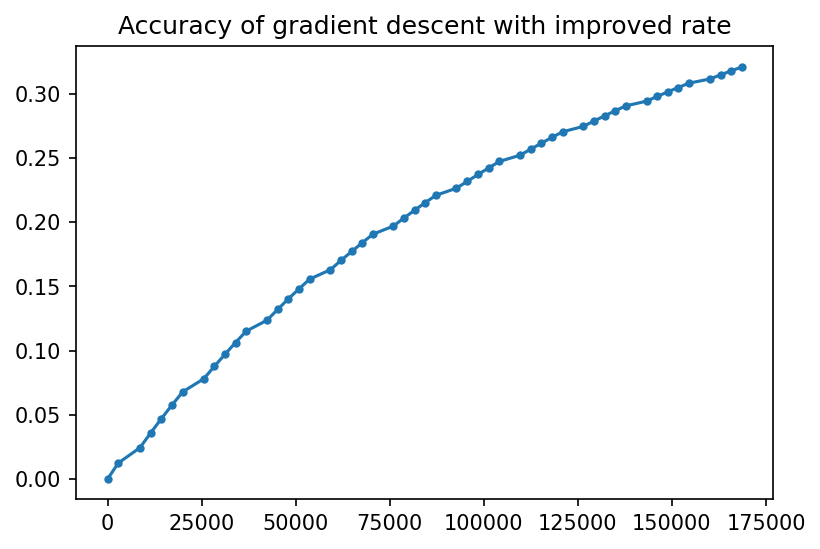

In [200]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of gradient descent with improved rate")
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [201]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(y_unlabeled_initial)

In [202]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(y_labeled, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(NUM_ITERS):

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
        create_frame_points_scale(i, x_unlabeled, y_unlabeled_gd_hb, "./gif/gd_hb/", "Heavy Ball")
        create_frame_points_binary(i, x_unlabeled, y_unlabeled_gd_hb, "./gif/gd_hb_binary/", "Heavy Ball")
        create_frame_loss(i, losses_gd_hb, "./gif/loss_gd_hb/", "Heavy Ball")

    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)

    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(y_labeled, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(y_labeled, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 50 - final accuracy 00.62% - loss 10844.57
10% - iter 5 / 50 - final accuracy 05.94% - loss 9384.63
20% - iter 10 / 50 - final accuracy 13.88% - loss 7938.56
30% - iter 15 / 50 - final accuracy 22.93% - loss 6847.43
40% - iter 20 / 50 - final accuracy 31.71% - loss 6170.77
50% - iter 25 / 50 - final accuracy 39.12% - loss 5836.69
60% - iter 30 / 50 - final accuracy 44.53% - loss 5719.90
70% - iter 35 / 50 - final accuracy 47.77% - loss 5690.31
80% - iter 40 / 50 - final accuracy 49.03% - loss 5673.86
90% - iter 45 / 50 - final accuracy 48.83% - loss 5657.82

Final accuracy: 48.02%
Norm gradient: 11.347132869505055
Loss: 5650.817707084619

CPU times: user 2min 50s, sys: 2min 2s, total: 4min 52s
Wall time: 2min 52s


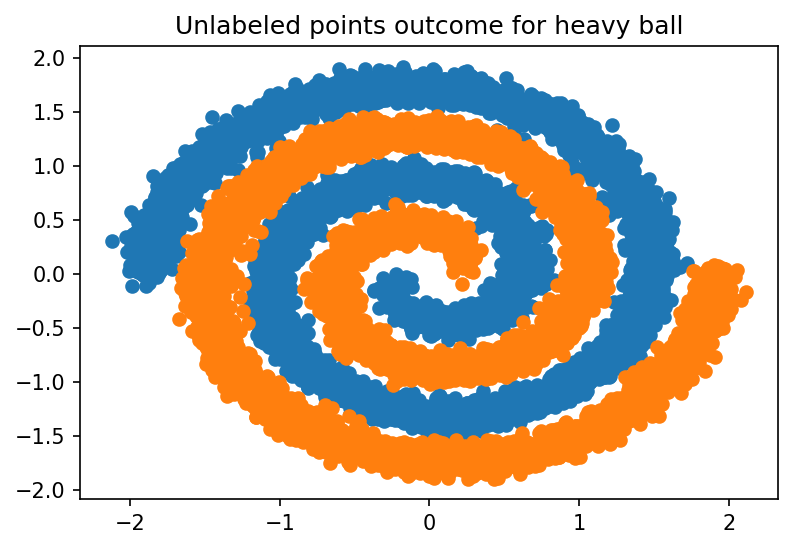

In [203]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for heavy ball")
    final_y_unlabeled = (y_unlabeled_gd_hb/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

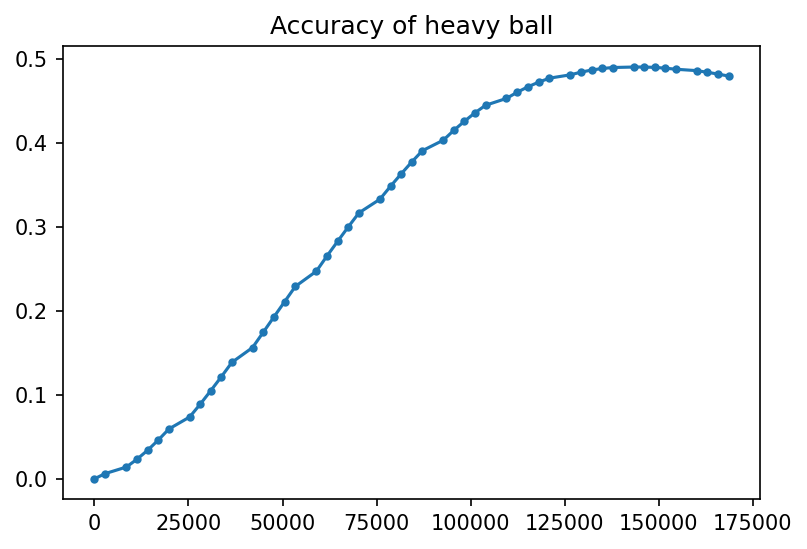

In [204]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of heavy ball")
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [205]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(y_unlabeled_initial)

In [206]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(y_labeled, y_unlabeled_gd_accelerated)]
Alpha = 1

for i in range(NUM_ITERS):

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
        create_frame_points_scale(i, x_unlabeled, y_unlabeled_gd_accelerated, "./gif/gd_accelerated/", "Accelerated Gradient")
        create_frame_points_binary(i, x_unlabeled, y_unlabeled_gd_accelerated, "./gif/gd_accelerated_binary/", "Accelerated Gradient")
        create_frame_loss(i, losses_gd_accelerated, "./gif/loss_gd_accelerated/", "Accelerated Gradient")

    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)

    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated
    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(y_labeled, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)


    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(y_labeled, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 50 - final accuracy 00.62% - loss 10844.57
10% - iter 5 / 50 - final accuracy 05.88% - loss 9404.49
20% - iter 10 / 50 - final accuracy 13.62% - loss 7979.42
30% - iter 15 / 50 - final accuracy 22.36% - loss 6894.25
40% - iter 20 / 50 - final accuracy 30.80% - loss 6209.62
50% - iter 25 / 50 - final accuracy 37.96% - loss 5857.18
60% - iter 30 / 50 - final accuracy 43.26% - loss 5717.87
70% - iter 35 / 50 - final accuracy 46.58% - loss 5675.40
80% - iter 40 / 50 - final accuracy 48.12% - loss 5659.58
90% - iter 45 / 50 - final accuracy 48.31% - loss 5648.90

Final accuracy: 47.85%
Norm gradient: 9.507962080379434
Loss: 5644.106286609948

CPU times: user 2min 49s, sys: 2min 3s, total: 4min 53s
Wall time: 2min 52s
Parser   : 315 ms


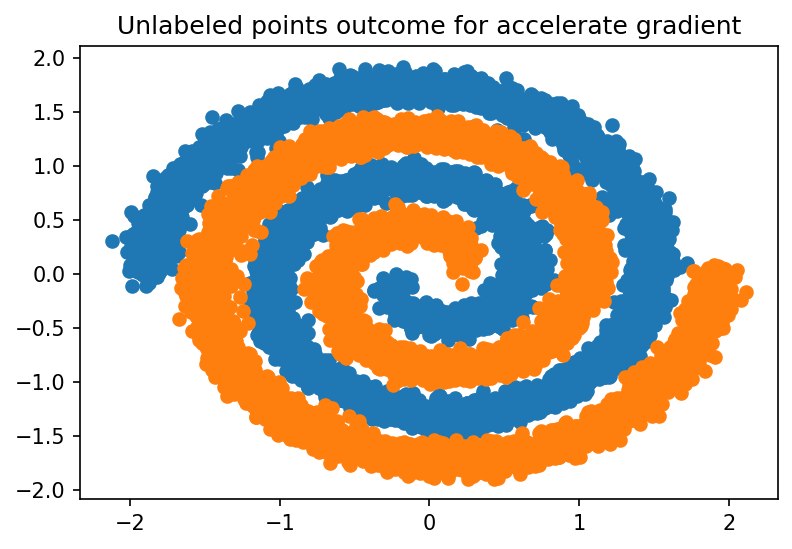

In [207]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for accelerate gradient")
    final_y_unlabeled = (y_unlabeled_gd_accelerated/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

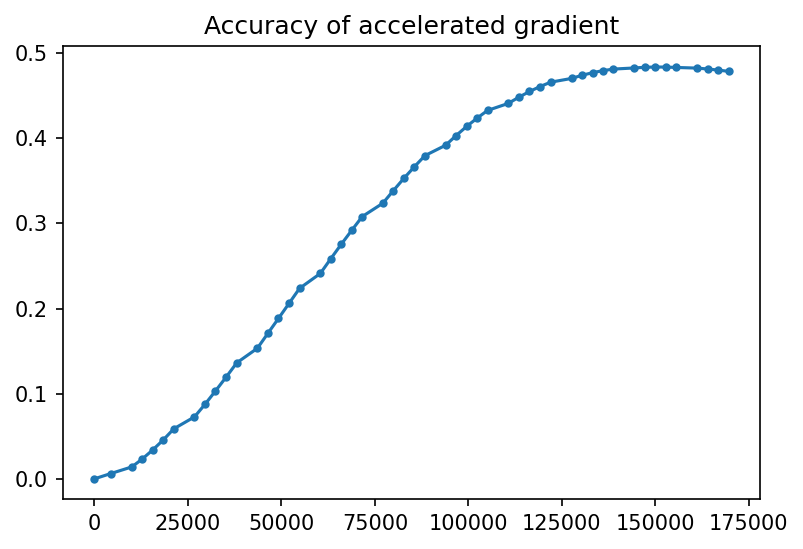

In [208]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of accelerated gradient")
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + 2 \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = 2[(\sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i]
\end{align*}
$$

In [209]:
def derivative(unlabeled, j):
    return 2 * (grad_first_coeff_vec[j] * unlabeled[j] -
           grad_second_coeff_vec[j] -
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T))

def update_gradient(previous_grad, Li, index):
    global w_unlabeled_unlabeled, grad_first_coeff_vec
    step = 1/Li * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += 2* w_unlabeled_unlabeled[index] * step
    new_grad[index] -= 2 * grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [210]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [211]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.choice(len(y_unlabeled_bcgd_random), max_iterations, p=optimized_sampling_probabilities) \
    if OPTIMIZE_RANDOM else np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2) and i % len(y_unlabeled_target) == 0:
        create_frame_points_scale(i // len(y_unlabeled_target),x_unlabeled, y_unlabeled_bcgd_random, "./gif/bcgd_random/", "BCGD Random")
        create_frame_points_binary(i // len(y_unlabeled_target),x_unlabeled, y_unlabeled_bcgd_random, "./gif/bcgd_random_binary/", "BCGD Random")
        create_frame_loss(i // len(y_unlabeled_target), losses_bcgm_random, "./gif/loss_bcgd_random/", "BCGM Random")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li[index], index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 693000 - final accuracy 00.00% - loss 11085.94
10% - iter 69300 / 693000 - final accuracy 02.96% - loss 10195.25
20% - iter 138600 / 693000 - final accuracy 05.69% - loss 9506.59
30% - iter 207900 / 693000 - final accuracy 08.19% - loss 8971.77
40% - iter 277200 / 693000 - final accuracy 10.52% - loss 8528.41
50% - iter 346500 / 693000 - final accuracy 12.68% - loss 8162.49
60% - iter 415800 / 693000 - final accuracy 14.69% - loss 7851.79
70% - iter 485100 / 693000 - final accuracy 16.55% - loss 7589.08
80% - iter 554400 / 693000 - final accuracy 18.29% - loss 7362.28
90% - iter 623700 / 693000 - final accuracy 19.91% - loss 7165.70

Final accuracy: 21.42%
Norm gradient: 109.47097488942676
Loss: 6995.271658236327

CPU times: user 2min 40s, sys: 31.2 s, total: 3min 11s
Wall time: 3min 5s


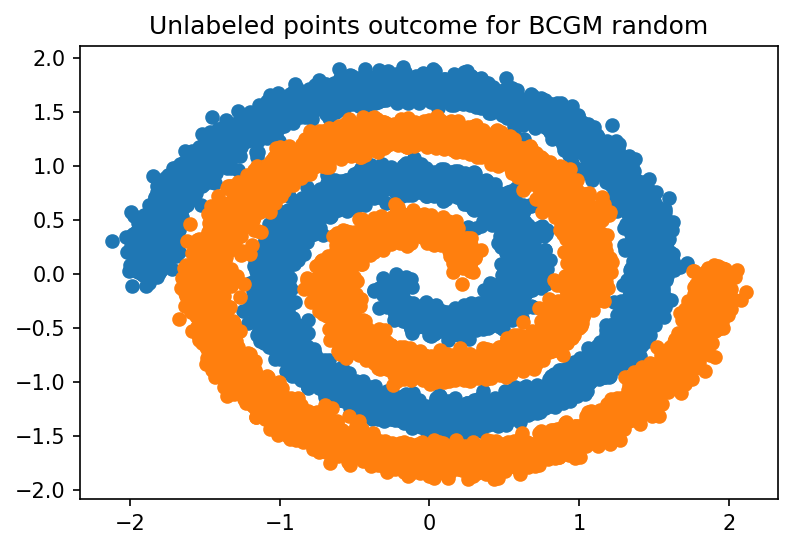

In [212]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM random")
    final_y_unlabeled = (y_unlabeled_bcgd_random/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

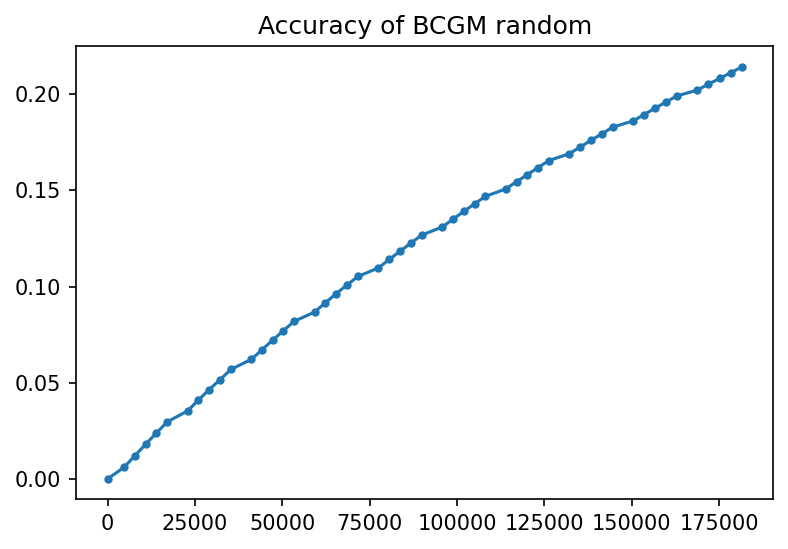

In [213]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM random")
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [214]:
y_unlabeled_bcgd_cyclic = np.copy(y_unlabeled_initial).astype("float64")

In [215]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(y_labeled, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")


    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2) and i % len(y_unlabeled_target) == 0:
        create_frame_points_scale(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_cyclic, "./gif/bcgd_cyclic/", "BCGD Cyclic")
        create_frame_points_binary(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_cyclic, "./gif/bcgd_cyclic_binary/", "BCGD Cyclic")
        create_frame_loss(i // len(y_unlabeled_target), losses_bcgm_cyclic, "./gif/loss_bcgd_cyclic/", "BCGM Cyclic")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li[index], index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(y_labeled, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 693000 - final accuracy 00.00% - loss 11085.93
10% - iter 69300 / 693000 - final accuracy 04.33% - loss 9781.79
20% - iter 138600 / 693000 - final accuracy 08.18% - loss 8932.92
30% - iter 207900 / 693000 - final accuracy 11.59% - loss 8311.51
40% - iter 277200 / 693000 - final accuracy 14.65% - loss 7834.70
50% - iter 346500 / 693000 - final accuracy 17.38% - loss 7458.95
60% - iter 415800 / 693000 - final accuracy 19.84% - loss 7157.65
70% - iter 485100 / 693000 - final accuracy 22.06% - loss 6913.05
80% - iter 554400 / 693000 - final accuracy 24.06% - loss 6712.69
90% - iter 623700 / 693000 - final accuracy 25.87% - loss 6547.40

Final accuracy: 27.51%
Norm gradient: 68.18058663495391
Loss: 6410.254719704384

CPU times: user 2min 39s, sys: 31 s, total: 3min 10s
Wall time: 3min 4s


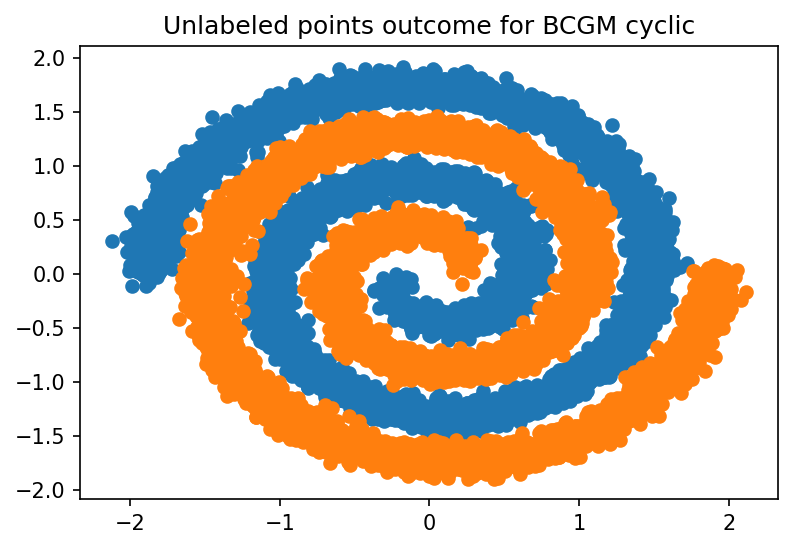

In [216]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM cyclic")
    final_y_unlabeled = (y_unlabeled_bcgd_cyclic/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

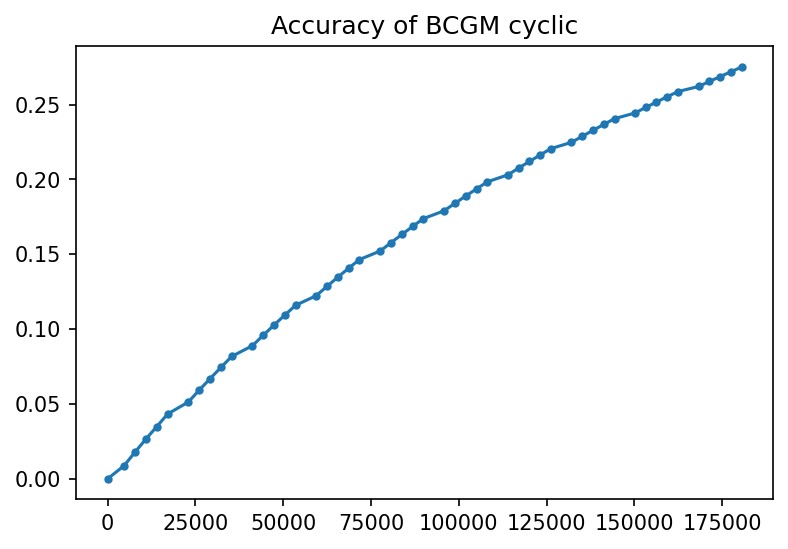

In [217]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM cyclic")
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [218]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [219]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2) and i % len(y_unlabeled_target) == 0:
        create_frame_points_scale(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs, "./gif/bcgd_gs/", "BCGD Gauss-Southwell")
        create_frame_points_binary(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs, "./gif/bcgd_gs_binary/", "BCGD Gauss-Southwell")
        create_frame_loss(i // len(y_unlabeled_target), losses_bcgm_gs, "./gif/loss_bcgd_gs/", "BCGM Gauss-Southwell")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li[index], index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 693000 - final accuracy 00.00% - loss 11085.77
10% - iter 69300 / 693000 - final accuracy 06.09% - loss 9231.23
20% - iter 138600 / 693000 - final accuracy 10.02% - loss 8491.37
30% - iter 207900 / 693000 - final accuracy 13.35% - loss 7967.66
40% - iter 277200 / 693000 - final accuracy 16.31% - loss 7549.96
50% - iter 346500 / 693000 - final accuracy 18.99% - loss 7210.41
60% - iter 415800 / 693000 - final accuracy 21.41% - loss 6932.30
70% - iter 485100 / 693000 - final accuracy 23.60% - loss 6704.23
80% - iter 554400 / 693000 - final accuracy 25.59% - loss 6516.51
90% - iter 623700 / 693000 - final accuracy 27.39% - loss 6361.91

Final accuracy: 29.03%
Norm gradient: 65.52863200028631
Loss: 6234.650041659876

CPU times: user 2min 45s, sys: 33.3 s, total: 3min 18s
Wall time: 3min 13s


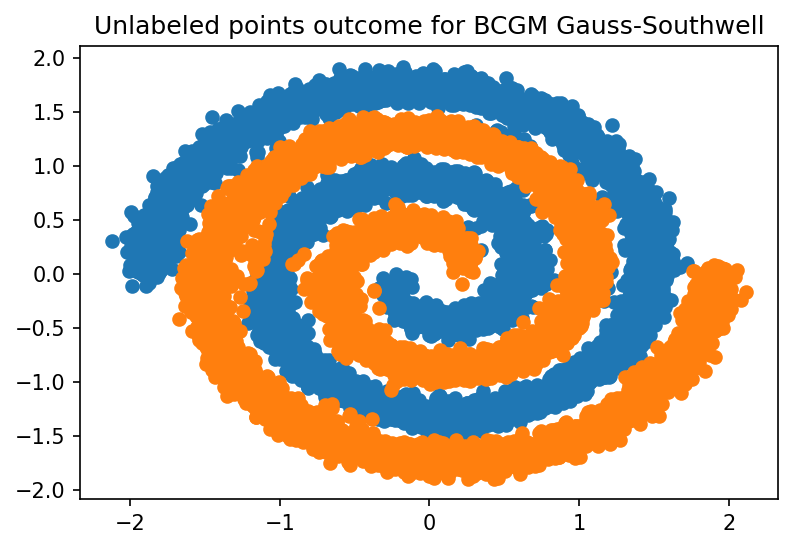

In [220]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM Gauss-Southwell")
    final_y_unlabeled = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

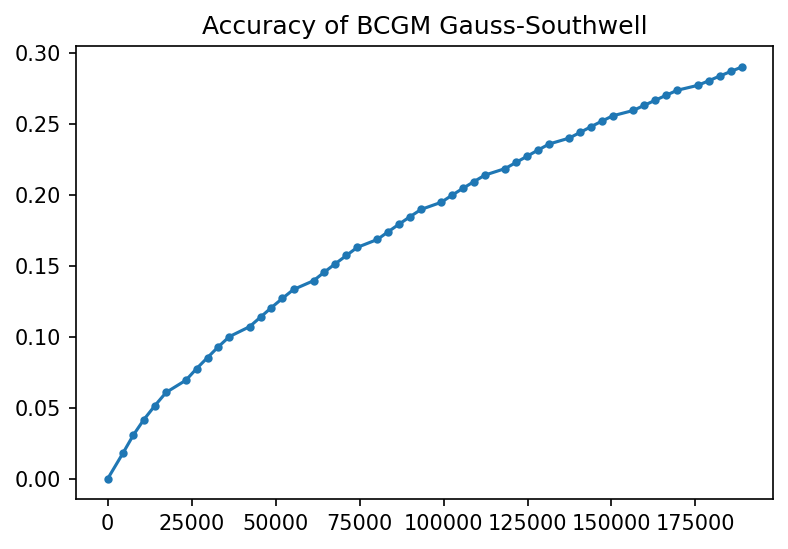

In [221]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM Gauss-Southwell")
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Gauss-Southwell exact line search

In [222]:
y_unlabeled_bcgd_gs_exact= np.copy(y_unlabeled_initial).astype("float64")

In [223]:
%%time
ticks_bcgd_gs_exact = [0]
accuracies_bcgd_gs_exact = [accuracy(y_unlabeled_bcgd_gs_exact)]
losses_bcgm_gs_exact = [loss(y_labeled, y_unlabeled_bcgd_gs_exact)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs_exact = gradient(y_unlabeled_bcgd_gs_exact)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2) and i % len(y_unlabeled_target) == 0:
        create_frame_points_scale(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs_exact, "./gif/bcgd_gs_exact/", "BCGD Gauss-Southwell with exact line search")
        create_frame_points_binary(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs_exact, "./gif/bcgd_gs_exact_binary/", "BCGD Gauss-Southwell with exact line search")
        create_frame_loss(i // len(y_unlabeled_target), losses_bcgm_gs_exact, "./gif/loss_bcgd_gs_exact/", "BCGM Gauss-Southwell with exact line search")

    index = np.argmax(np.abs(previous_grad_gs_exact))

    alpha_exact = -1/(2 * (w_unlabeled_unlabeled[index][index] - grad_first_coeff_vec[index]))
    step, new_grad = update_gradient(previous_grad_gs_exact, 1/alpha_exact, index)
    y_unlabeled_bcgd_gs_exact[index] = y_unlabeled_bcgd_gs_exact[index] - step
    previous_grad_gs_exact = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs_exact):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_gs_exact.append(accuracy(y_unlabeled_bcgd_gs_exact))
        losses_bcgm_gs_exact.append(loss(y_labeled, y_unlabeled_bcgd_gs_exact))
        ticks_bcgd_gs_exact.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs_exact[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs_exact):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs_exact[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs_exact))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs_exact)}
""")

00% - iter 0 / 693000 - final accuracy 00.00% - loss 11085.77
10% - iter 69300 / 693000 - final accuracy 10.08% - loss 8491.18
20% - iter 138600 / 693000 - final accuracy 16.51% - loss 7528.88
30% - iter 207900 / 693000 - final accuracy 21.68% - loss 6906.09
40% - iter 277200 / 693000 - final accuracy 25.90% - loss 6490.35
50% - iter 346500 / 693000 - final accuracy 29.37% - loss 6210.25
60% - iter 415800 / 693000 - final accuracy 32.23% - loss 6021.45
70% - iter 485100 / 693000 - final accuracy 34.58% - loss 5893.77
80% - iter 554400 / 693000 - final accuracy 36.51% - loss 5807.48
90% - iter 623700 / 693000 - final accuracy 38.09% - loss 5749.05

Final accuracy: 39.4%
Norm gradient: 26.41006090941383
Loss: 5709.505121377581

CPU times: user 2min 48s, sys: 33.6 s, total: 3min 22s
Wall time: 3min 17s


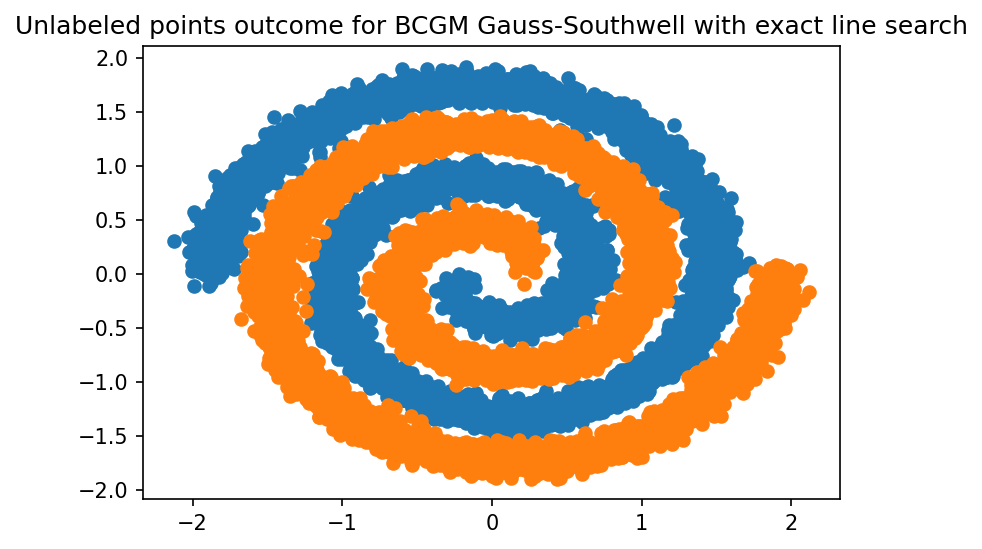

In [224]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM Gauss-Southwell with exact line search")
    final_y_unlabeled = (y_unlabeled_bcgd_gs_exact/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

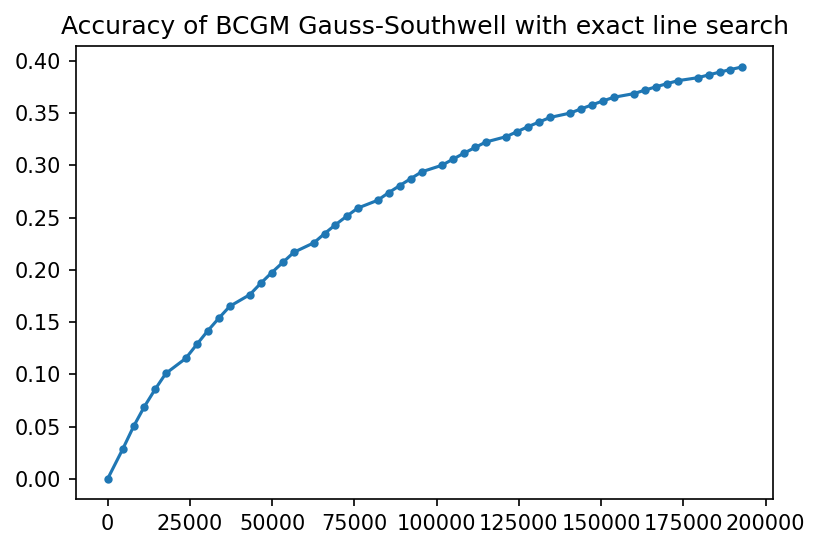

In [225]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM Gauss-Southwell with exact line search")
pl.plot(ticks_bcgd_gs_exact, accuracies_bcgd_gs_exact, marker='.')

## Comparison

As we can see, the BCGM cyclic is the fastest, since using the Lipschitz constant for the single bloc, after one iteration (considered as one complete cycle over all the blocks) finds the best solution, followed by the BCGM random, which also exploits the Lipschitz fo the singe variable to have a better estimate of the stepsize.
In last position we find the Gradient Descent, which is slower due to the stepsize estimated using the Lipschitz constant of the whole problem, which is the highest eigenvalue, and therefore is just a "safe" upper bound

### All algorithms compared

In [226]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs, accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs, accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
min_y_plot = min_acc - .1 * (1 - min_acc)
max_y_plot = max_acc + (.1 * (1 - max_acc))

#### Accuracy

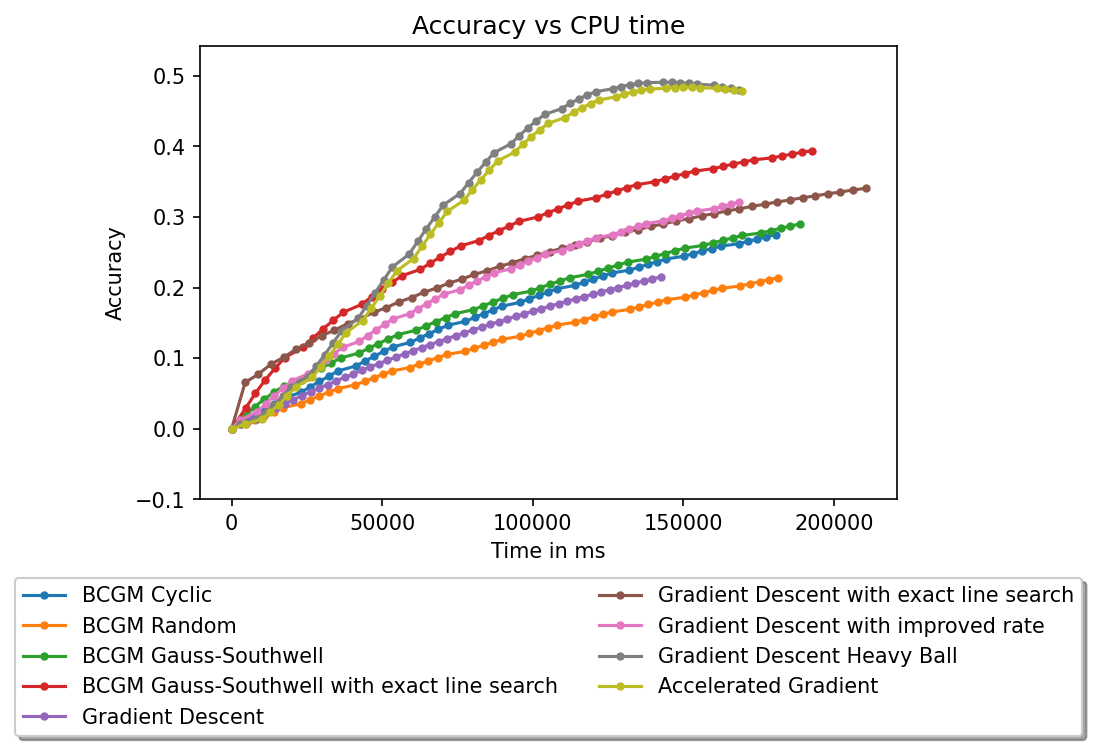

In [227]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
pl.plot(ticks_bcgd_gs_exact, accuracies_bcgd_gs_exact, marker='.')
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.plot(ticks_gd_exact, accuracies_gd_exact, marker='.')
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

pl.title("Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauss-Southwell with exact line search',
        'Gradient Descent',
        'Gradient Descent with exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

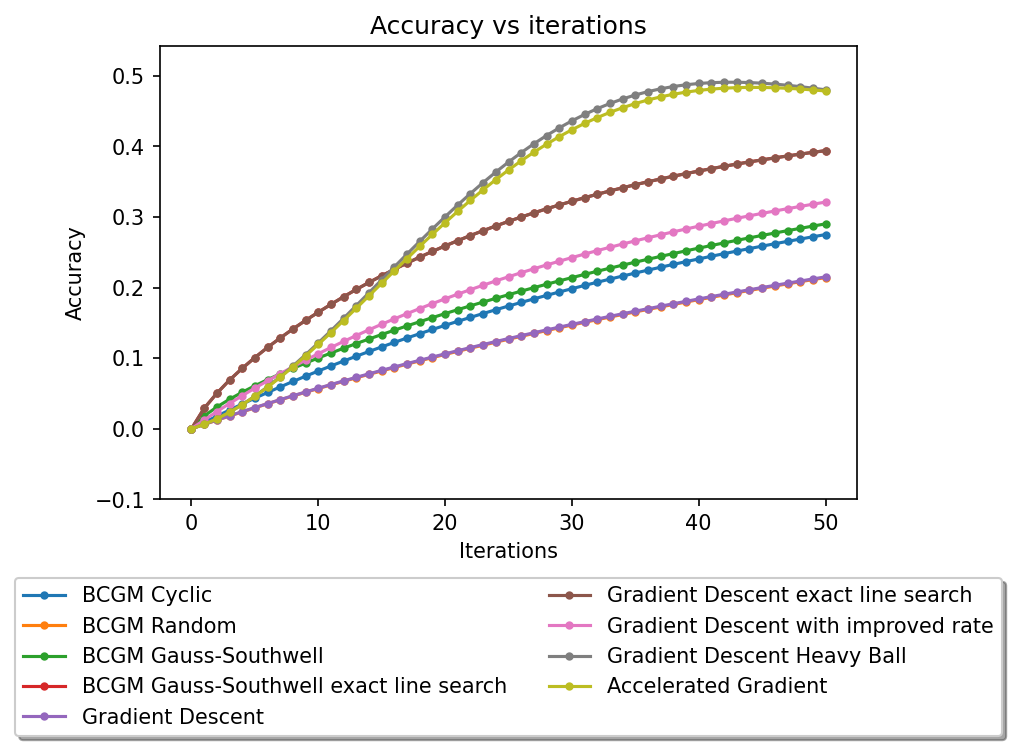

In [228]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_bcgd_cyclic, marker='.')
pl.plot(accuracies_bcgd_random, marker='.')
pl.plot(accuracies_bcgd_gs, marker='.')
pl.plot(accuracies_bcgd_gs_exact, marker='.')
pl.plot(accuracies_gd, marker='.')
pl.plot(accuracies_bcgd_gs_exact, marker='.')
pl.plot(accuracies_gd_improved, marker='.')
pl.plot(accuracies_gd_hb, marker='.')
pl.plot(accuracies_gd_accelerated, marker='.')

pl.title("Accuracy vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Accuracy")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauss-Southwell exact line search',
        'Gradient Descent',
        'Gradient Descent exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

#### Loss

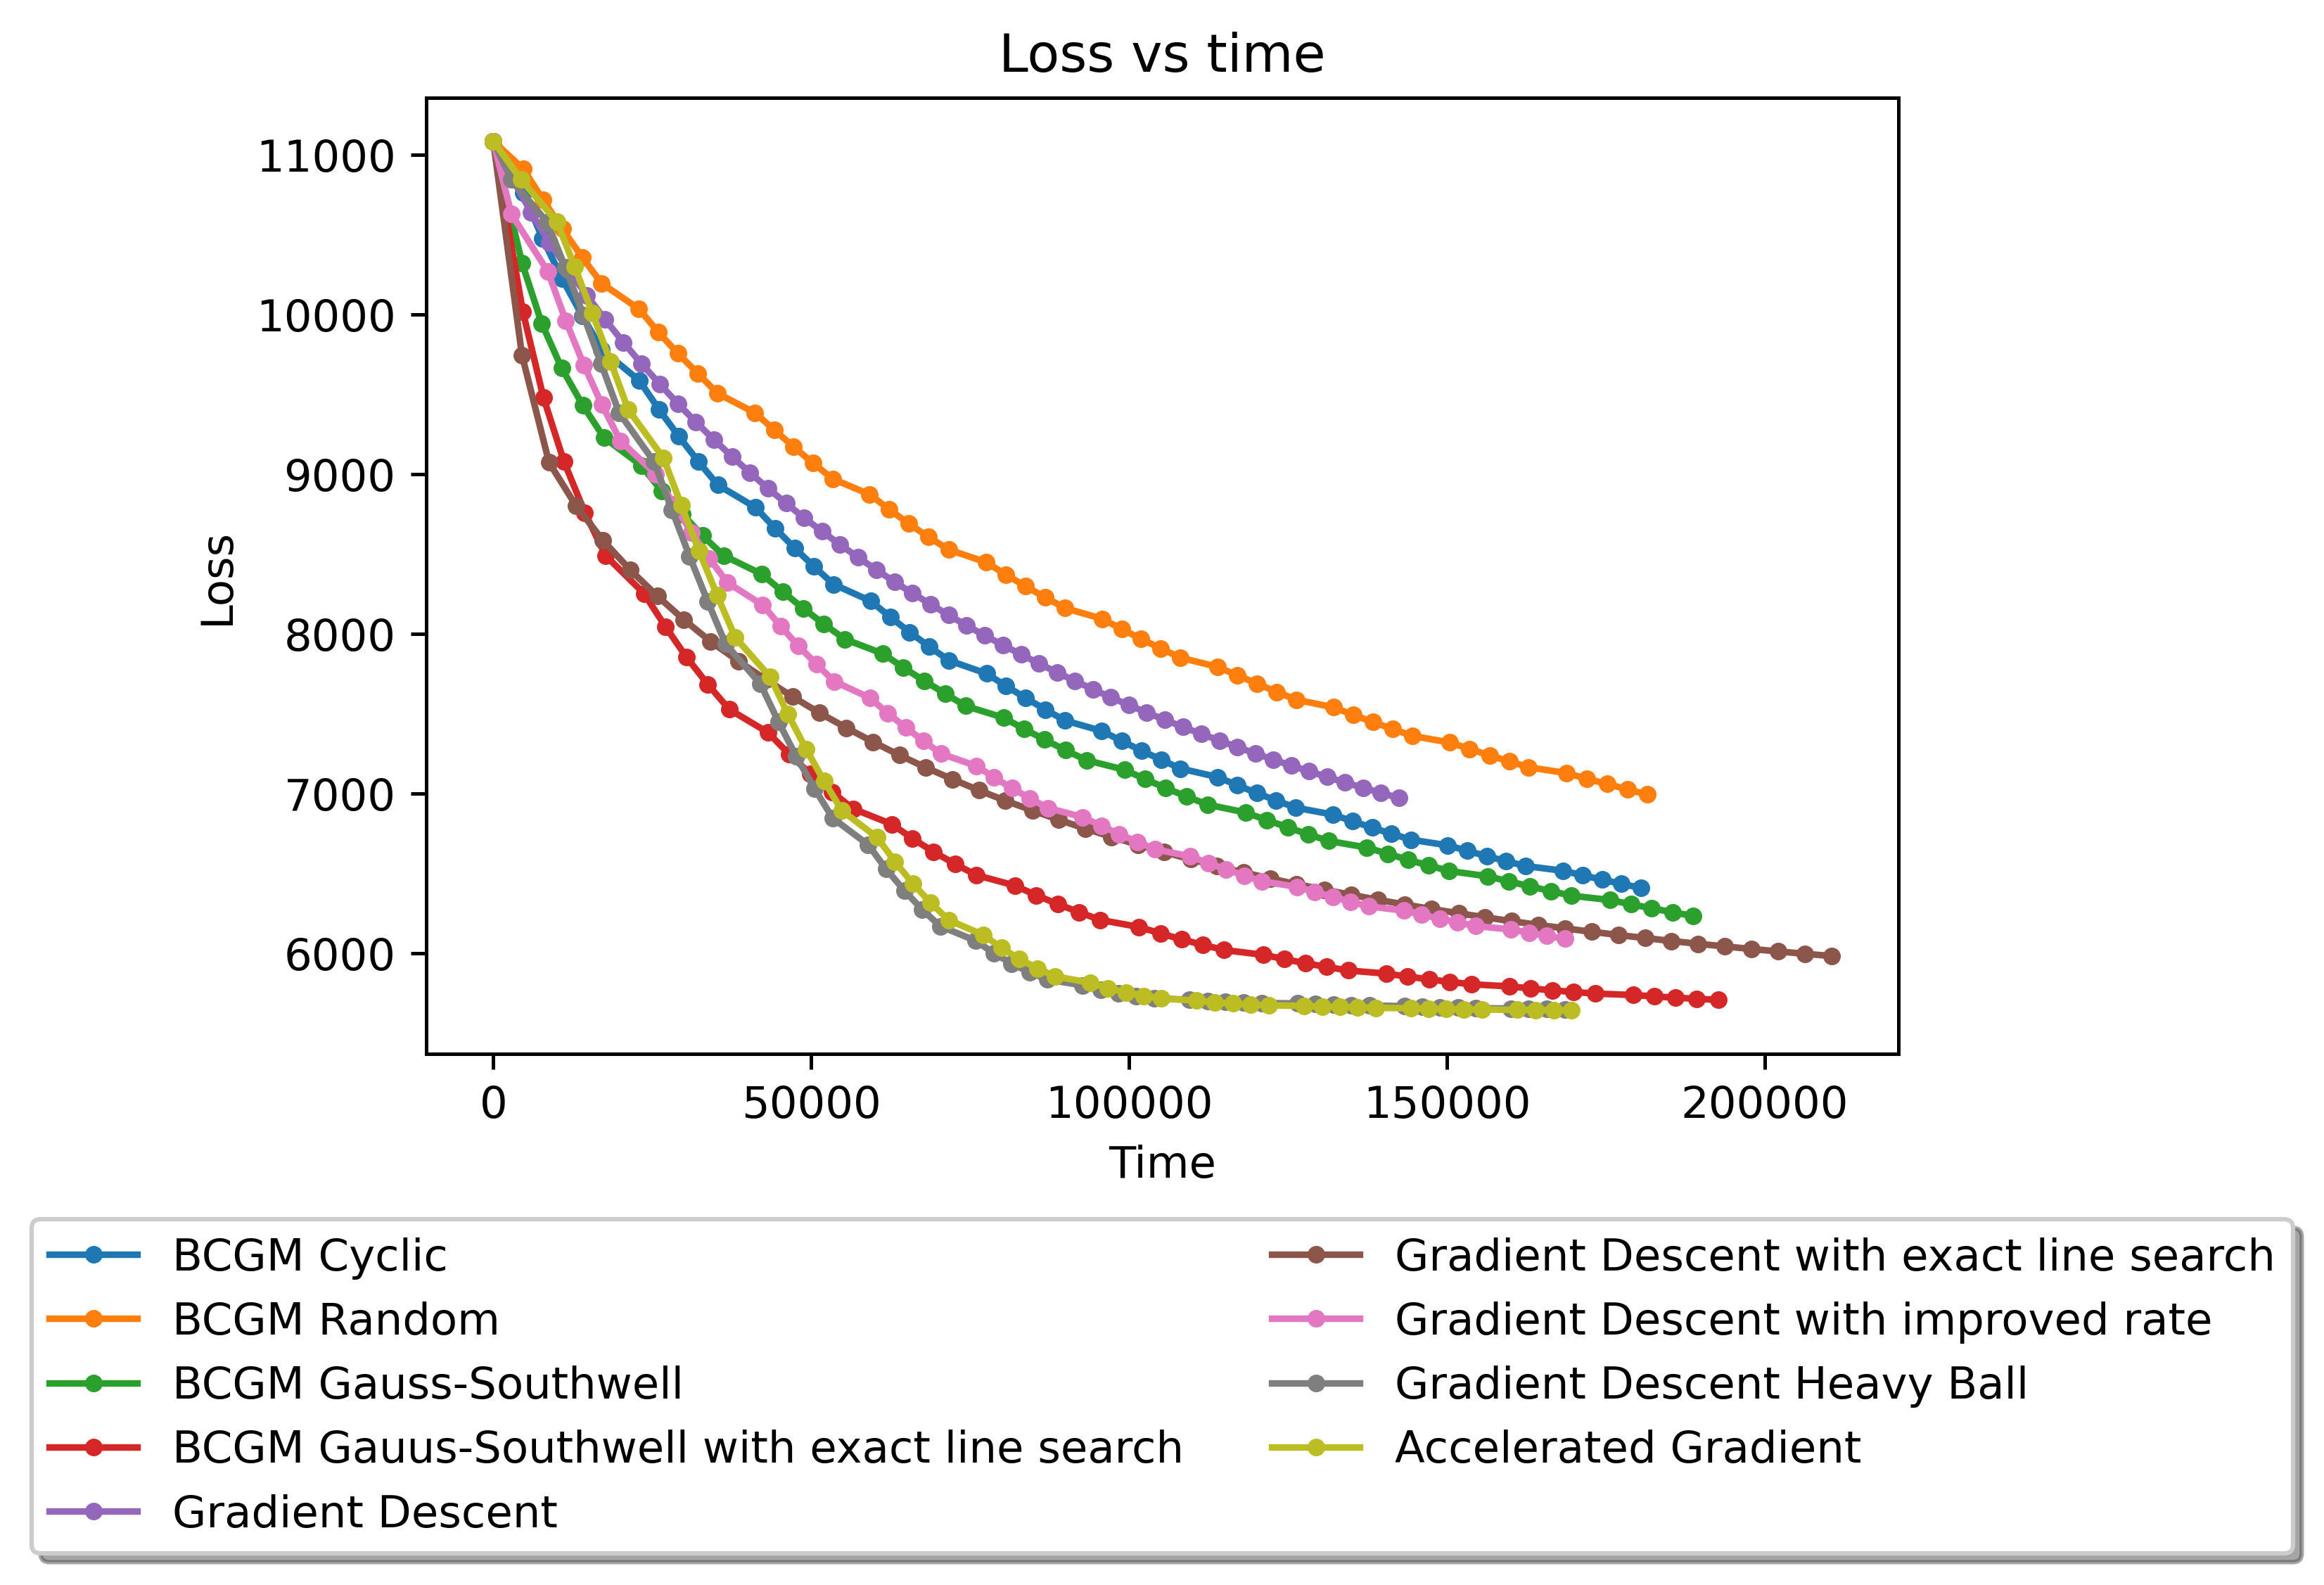

In [229]:
pl.figure(dpi=PLOT_DPI*3)
pl.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
pl.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
pl.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
pl.plot(ticks_bcgd_gs_exact, losses_bcgm_gs_exact, marker='.')
pl.plot(ticks_gd , losses_gd, marker='.')
pl.plot(ticks_gd_exact , losses_gd_exact, marker='.')
pl.plot(ticks_gd_improved , losses_gd_improved, marker='.')
pl.plot(ticks_gd_hb , losses_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

pl.title("Loss vs time")
pl.xlabel("Time")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauus-Southwell with exact line search',
        'Gradient Descent',
        'Gradient Descent with exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)

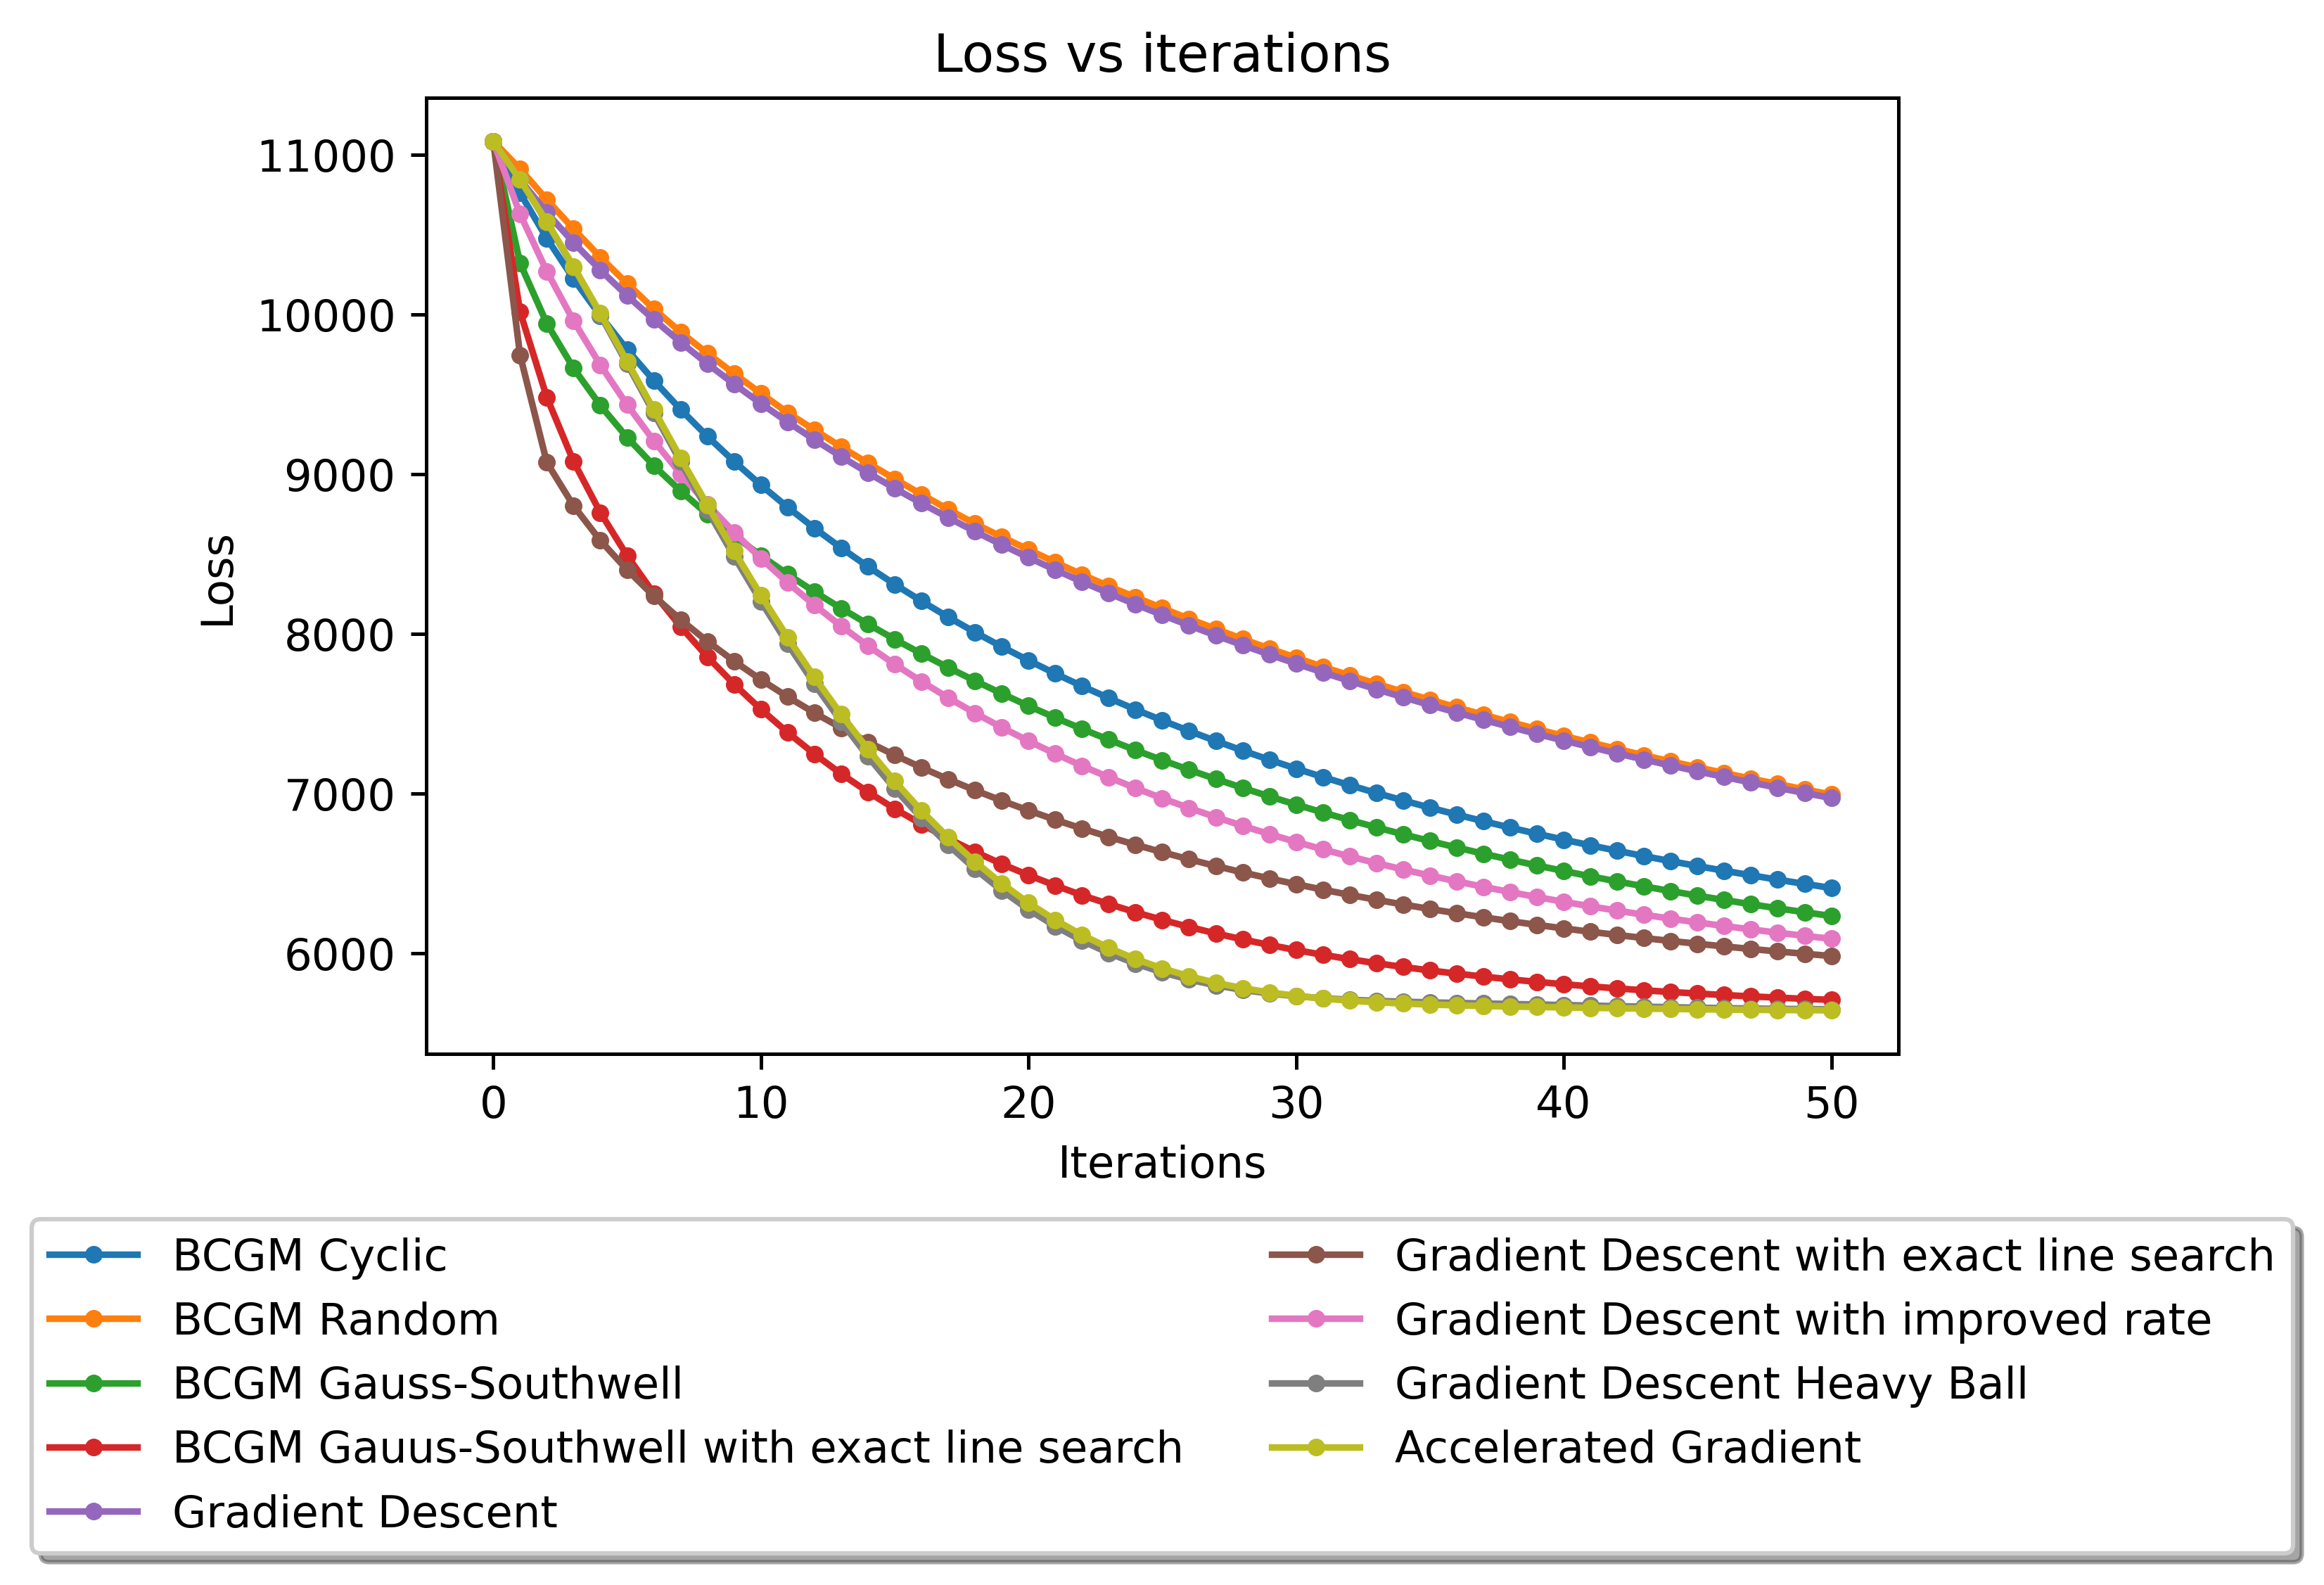

In [230]:
pl.figure(dpi=PLOT_DPI*3)
pl.plot(losses_bcgm_cyclic, marker='.')
pl.plot(losses_bcgm_random, marker='.')
pl.plot(losses_bcgm_gs, marker='.')
pl.plot(losses_bcgm_gs_exact, marker='.')
pl.plot(losses_gd, marker='.')
pl.plot(losses_gd_exact, marker='.')
pl.plot(losses_gd_improved, marker='.')
pl.plot(losses_gd_hb, marker='.')
pl.plot(losses_gd_accelerated, marker='.')

pl.title("Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauus-Southwell with exact line search',
        'Gradient Descent',
        'Gradient Descent with exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

#### Grid

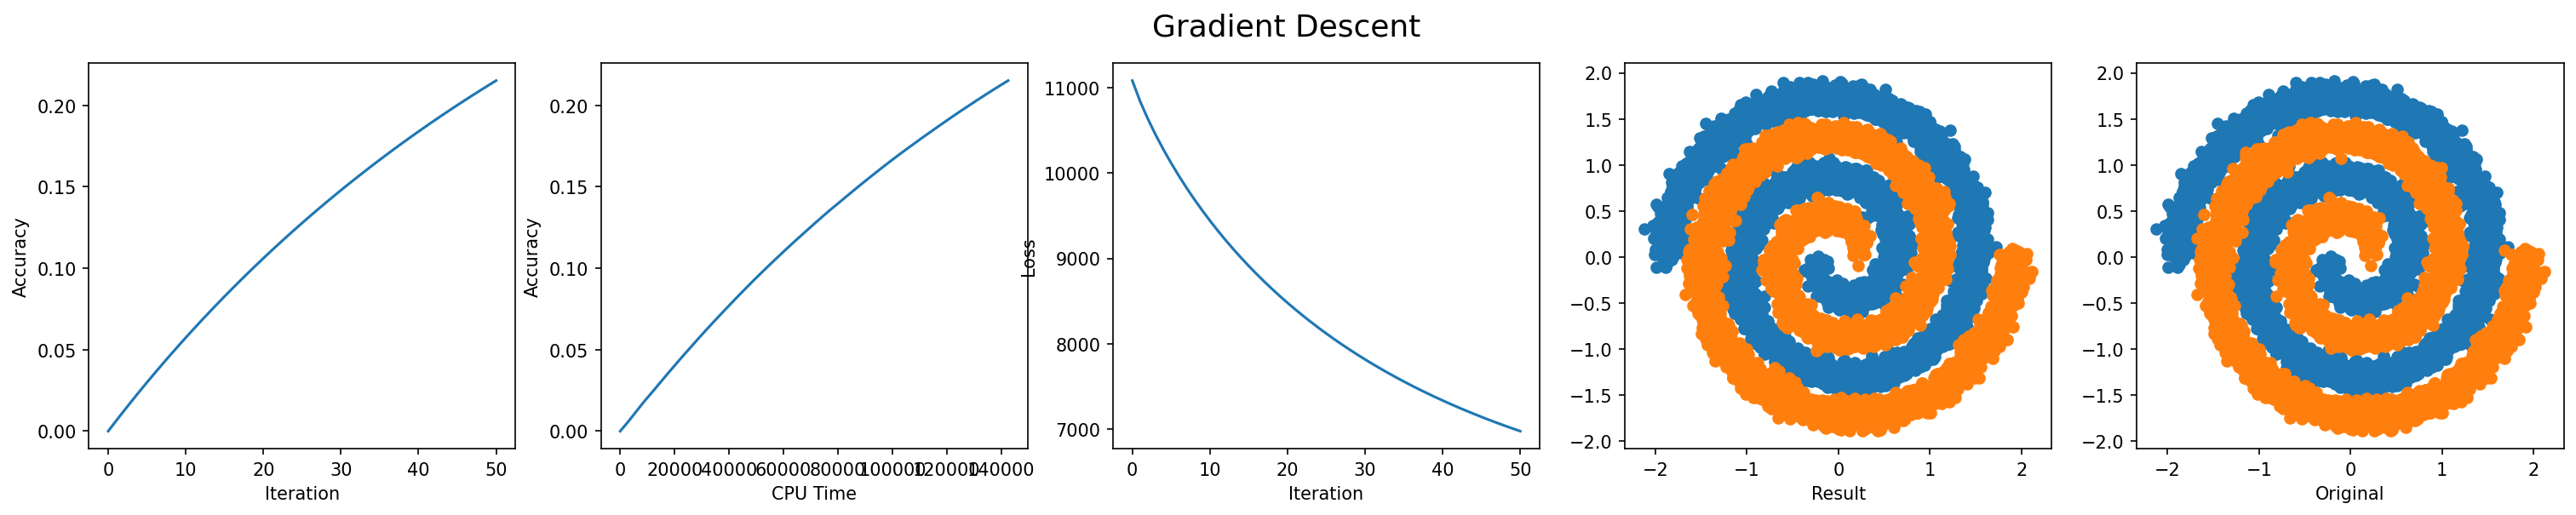

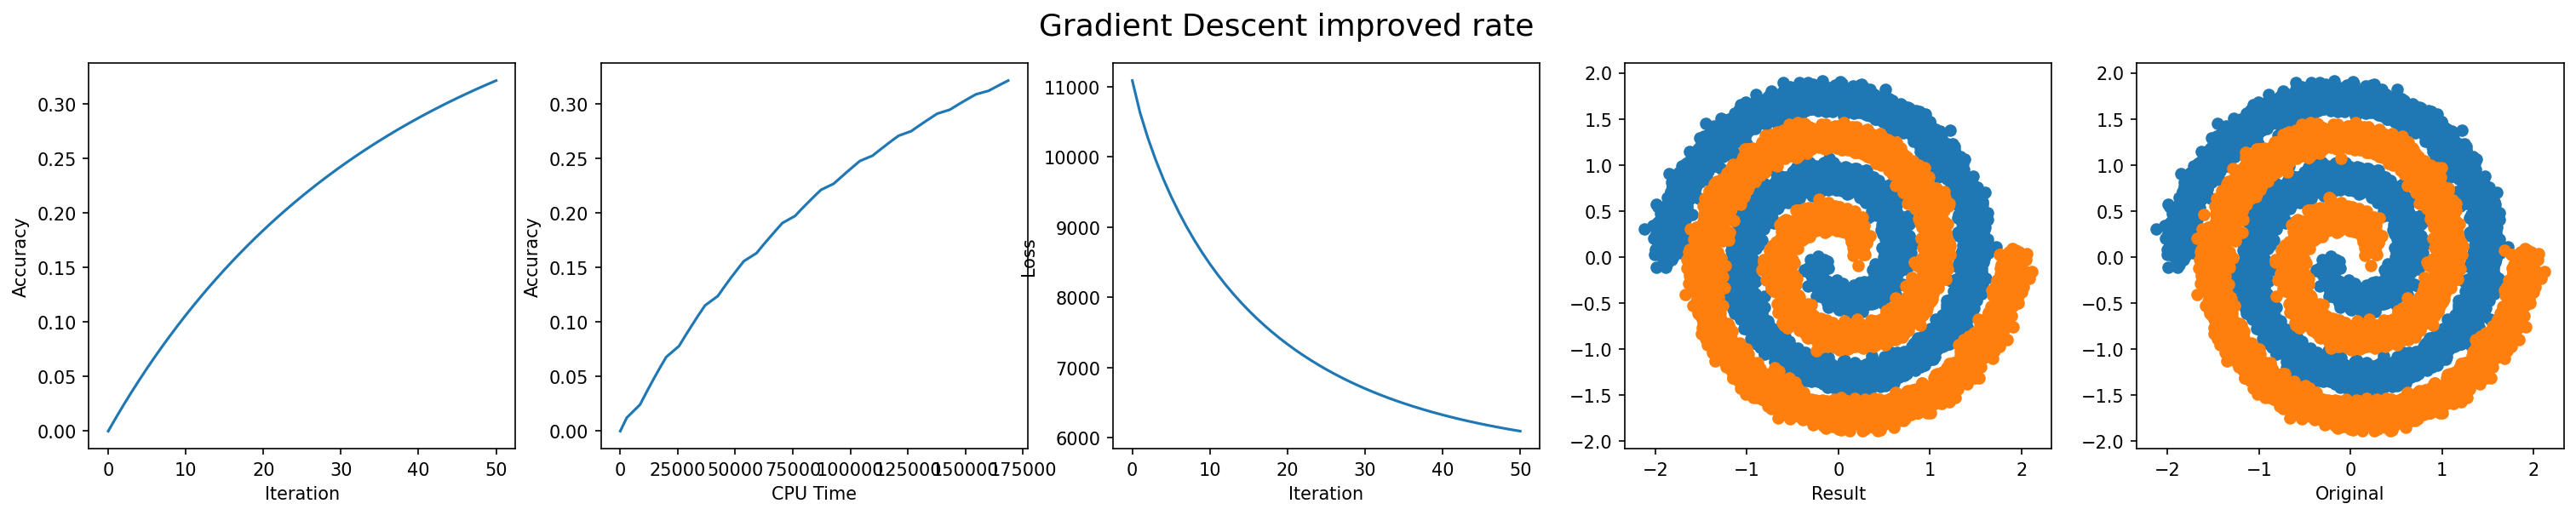

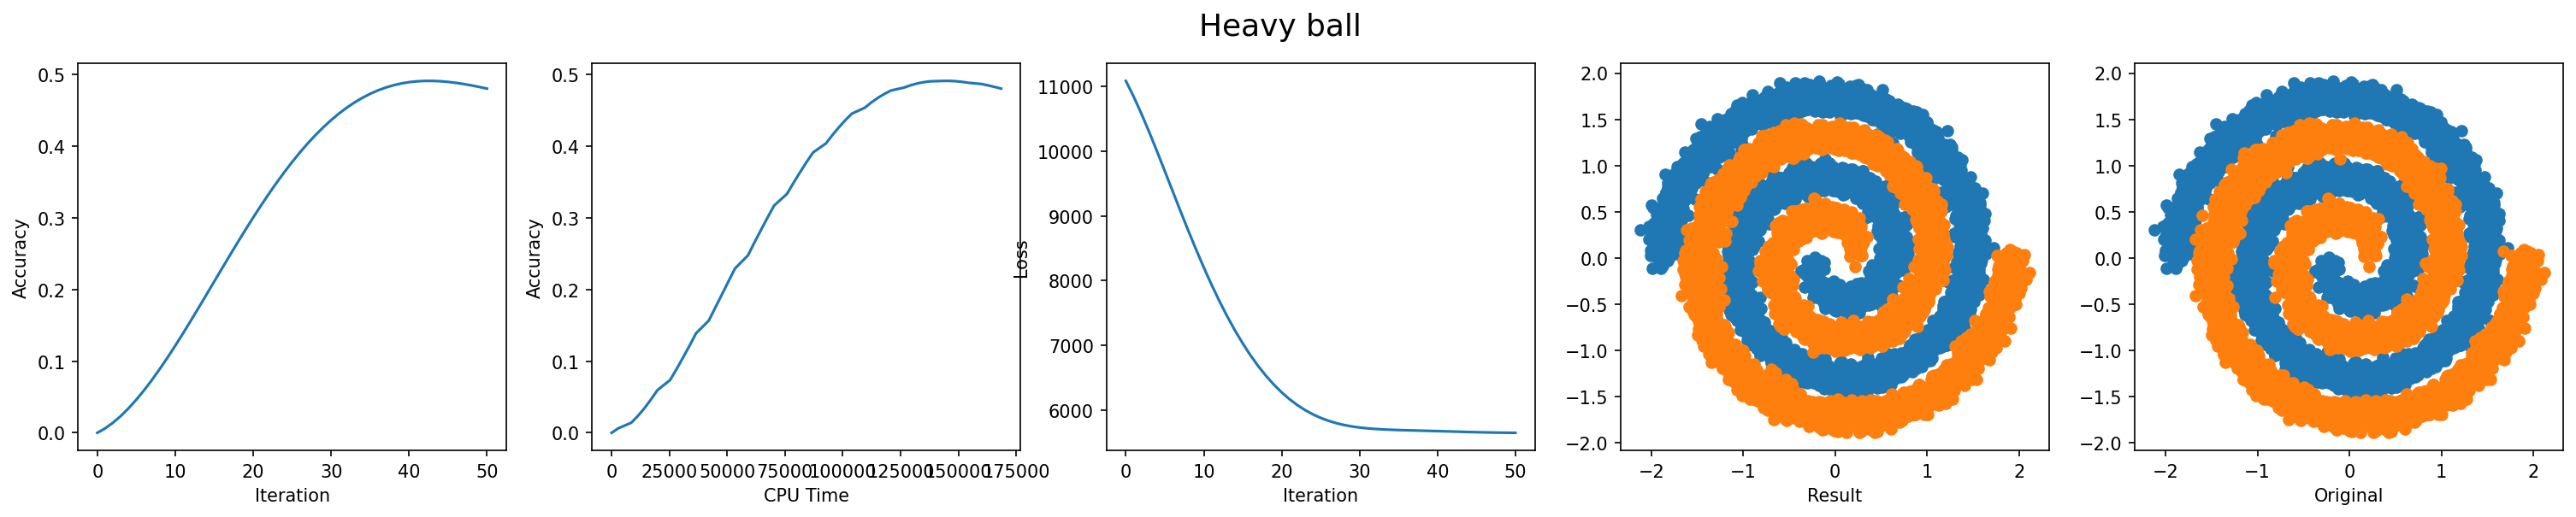

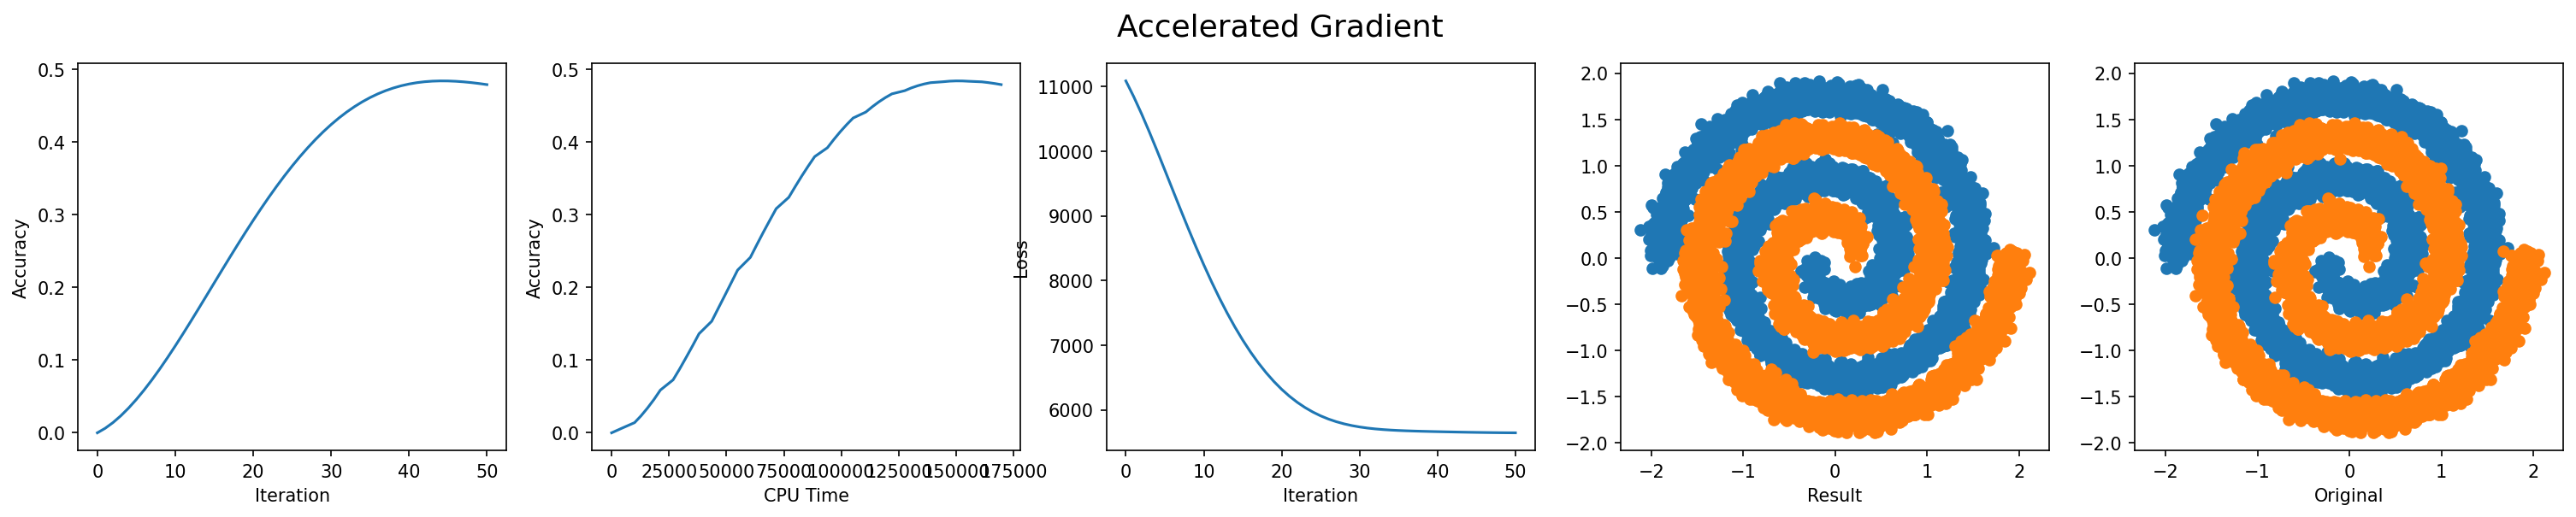

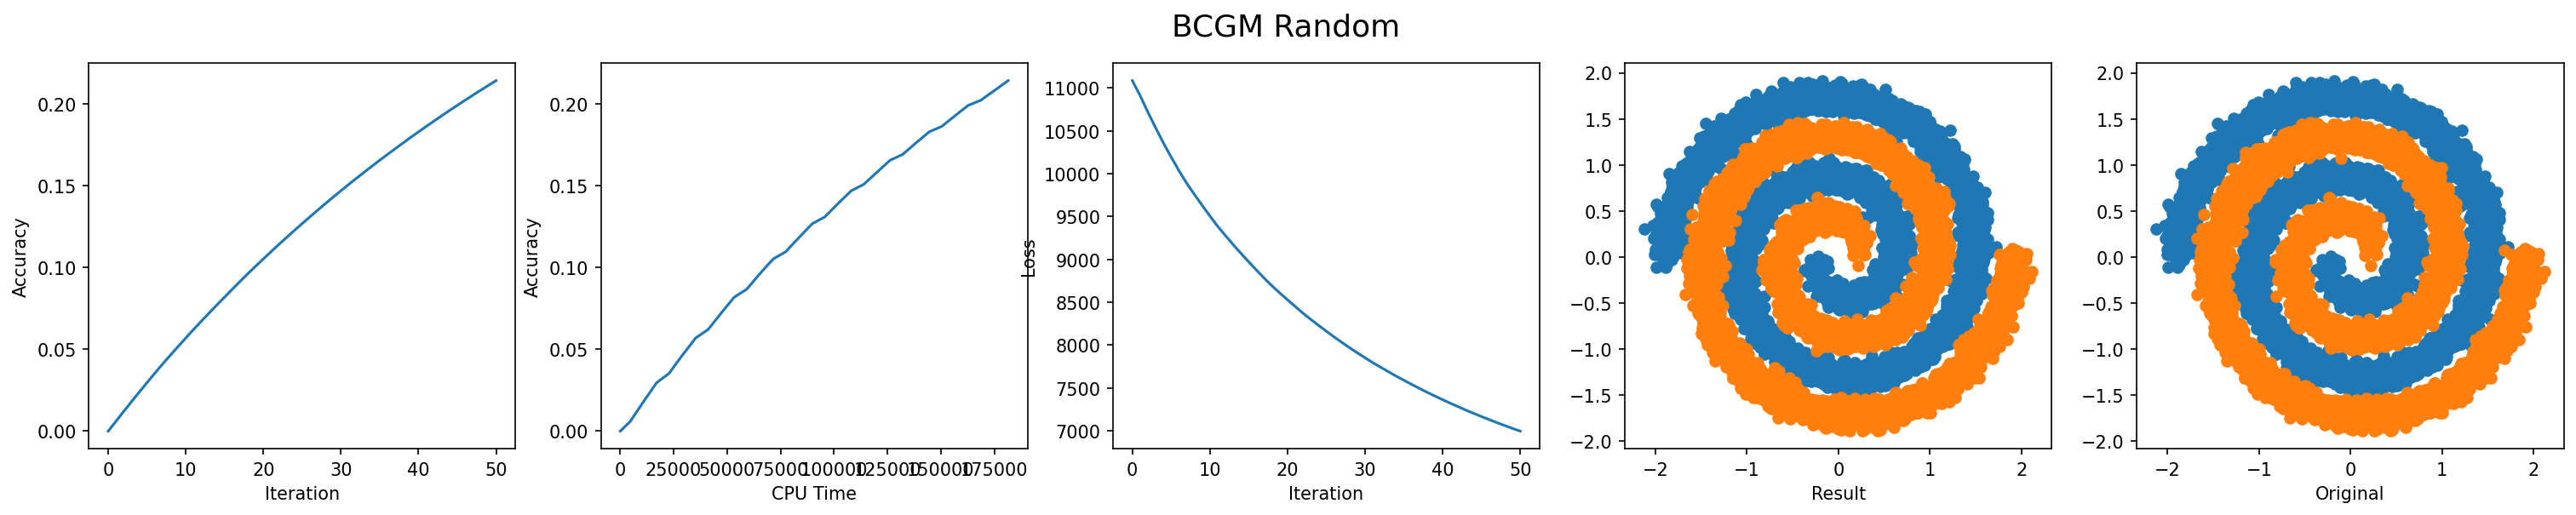

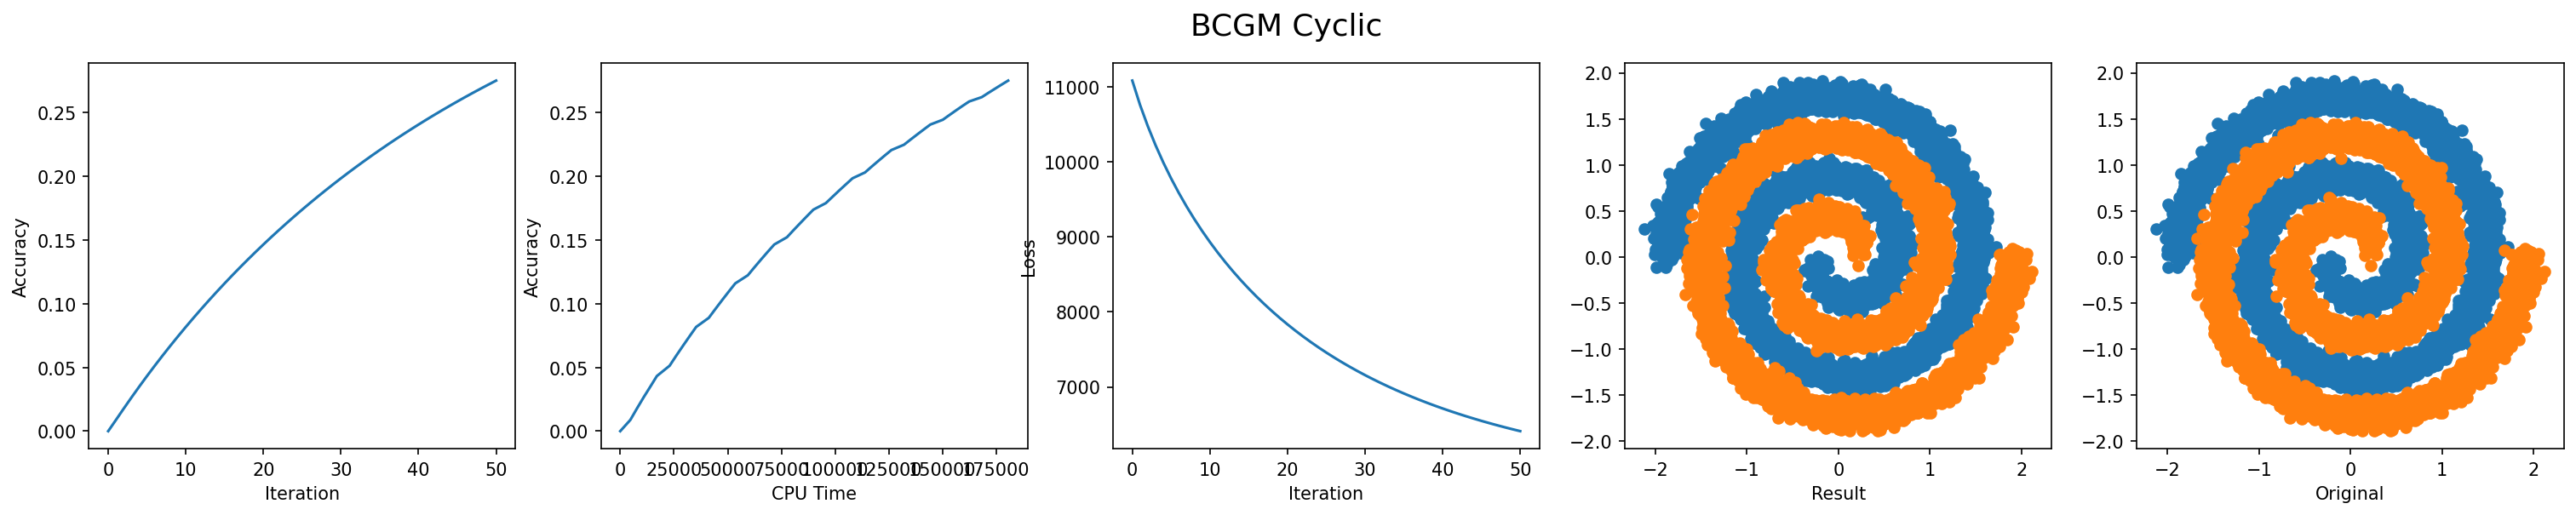

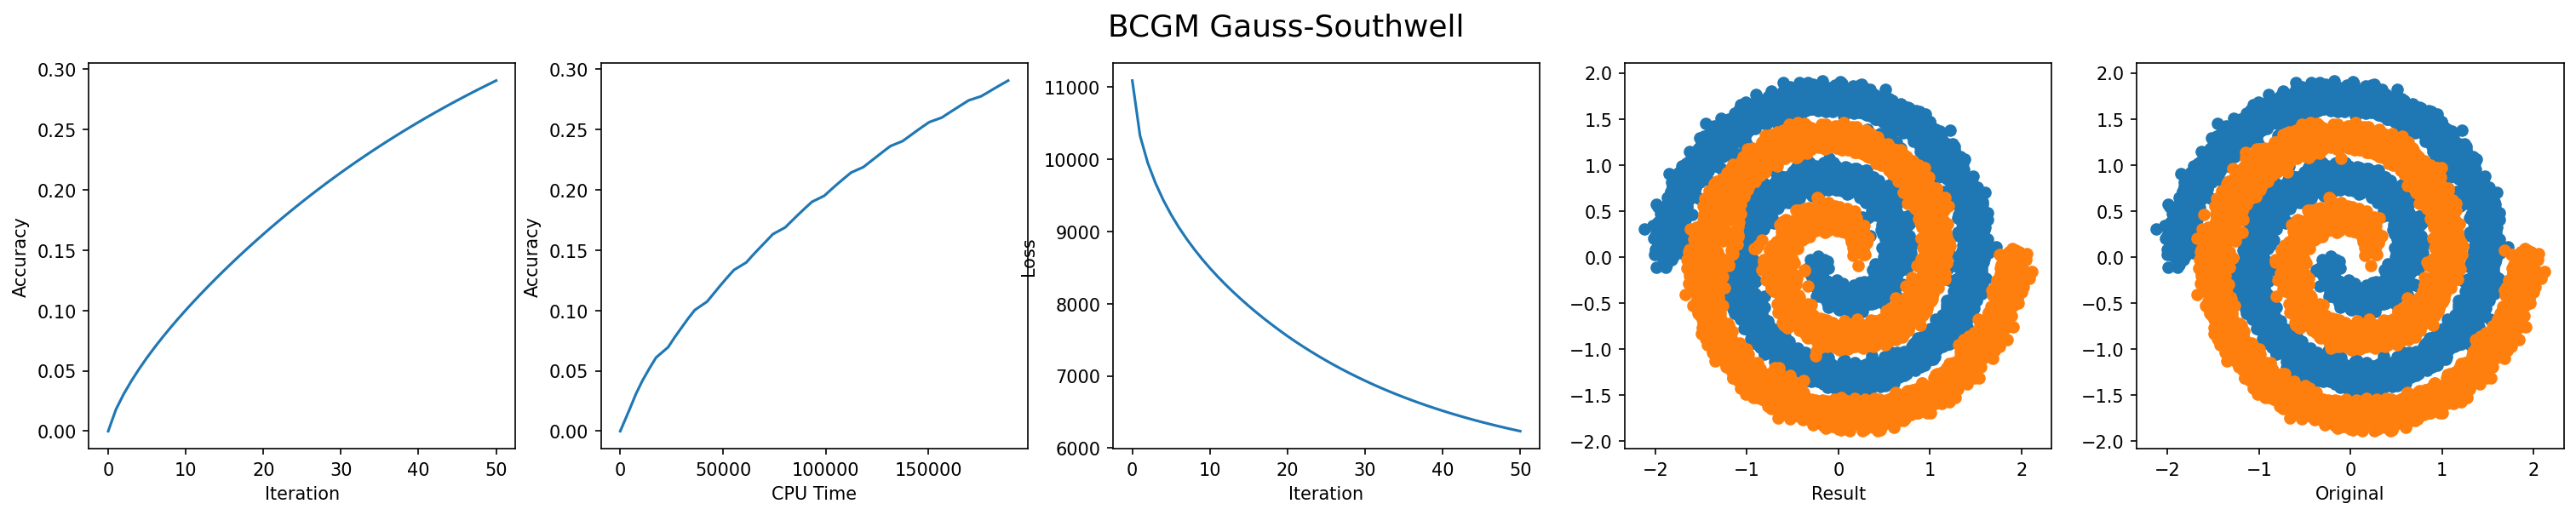

In [231]:
def plots(title, y_unlabeled, ticks, accuracies, losses):
    number_of_subplots = 3 if FROM_DATASET and x_labeled.shape[1] > 2 else 5
    fig, axs = pl.subplots(1 ,number_of_subplots, dpi=PLOT_DPI, figsize=(25, 4))
    fig.suptitle(title, fontsize="xx-large")
    if number_of_subplots > 3:
        axs[3].scatter([p[0] for p in x_unlabeled[y_unlabeled > 0]], [p[1] for p in x_unlabeled[y_unlabeled > 0]])
        axs[3].scatter([p[0] for p in x_unlabeled[y_unlabeled <= 0]], [p[1] for p in x_unlabeled[y_unlabeled <= 0]])
        axs[3].set(xlabel='Result')
        axs[4].set(xlabel='Original')
        axs[4].scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]])
        axs[4].scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]])
    axs[1].plot(ticks, accuracies)
    axs[1].set(xlabel='CPU Time', ylabel='Accuracy')
    axs[0].plot(accuracies)
    axs[0].set(xlabel='Iteration', ylabel='Accuracy')
    axs[2].plot(losses)
    axs[2].set(xlabel='Iteration', ylabel='Loss')
    pl.show()

for data in [
    ["Gradient Descent", y_unlabeled_gd, ticks_gd, accuracies_gd, losses_gd],
    ["Gradient Descent improved rate", y_unlabeled_gd_improved, ticks_gd_improved, accuracies_gd_improved, losses_gd_improved],
    ["Heavy ball", y_unlabeled_gd_hb, ticks_gd_hb, accuracies_gd_hb, losses_gd_hb],
    ["Accelerated Gradient", y_unlabeled_gd_accelerated, ticks_gd_accelerated, accuracies_gd_accelerated, losses_gd_accelerated],
    ["BCGM Random", y_unlabeled_bcgd_random, ticks_bcgd_random, accuracies_bcgd_random, losses_bcgm_random],
    ["BCGM Cyclic", y_unlabeled_bcgd_cyclic, ticks_bcgd_cyclic, accuracies_bcgd_cyclic, losses_bcgm_cyclic],
    ["BCGM Gauss-Southwell", y_unlabeled_bcgd_gs, ticks_bcgd_gs, accuracies_bcgd_gs, losses_bcgm_gs],
]:
    plots(*data)


### Only BCGM compared

In [232]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
min_y_plot = min_acc - .1 * (1 - min_acc)
max_y_plot = max_acc + (.1 * (1 - max_acc))

#### Accuracy

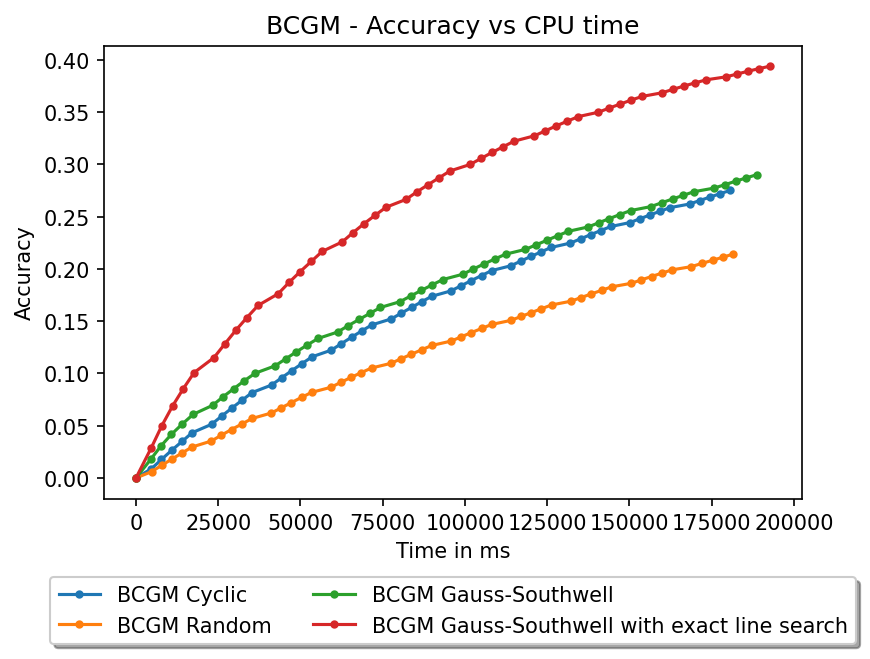

In [233]:
pl.figure(dpi=PLOT_DPI)
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
pl.plot(ticks_bcgd_gs_exact, accuracies_bcgd_gs_exact, marker='.')

pl.title("BCGM - Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    ['BCGM Cyclic', 'BCGM Random', 'BCGM Gauss-Southwell', 'BCGM Gauss-Southwell with exact line search'],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

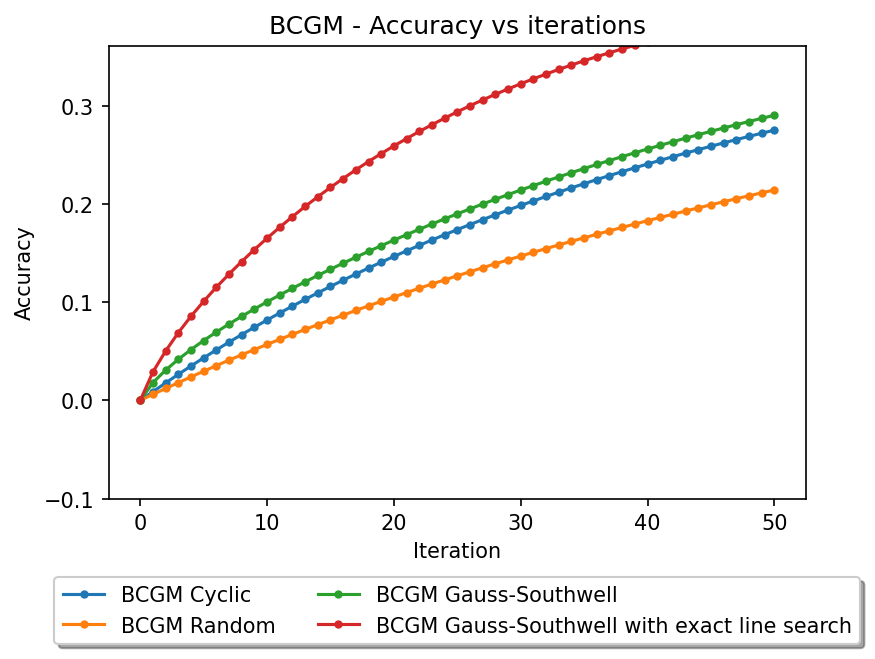

In [234]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_bcgd_cyclic, marker='.')
pl.plot(accuracies_bcgd_random, marker='.')
pl.plot(accuracies_bcgd_gs, marker='.')
pl.plot(accuracies_bcgd_gs_exact, marker='.')

pl.title("BCGM - Accuracy vs iterations")
pl.xlabel("Iteration")
pl.ylabel("Accuracy")
pl.legend(
    ['BCGM Cyclic', 'BCGM Random', 'BCGM Gauss-Southwell', 'BCGM Gauss-Southwell with exact line search'],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

#### Loss

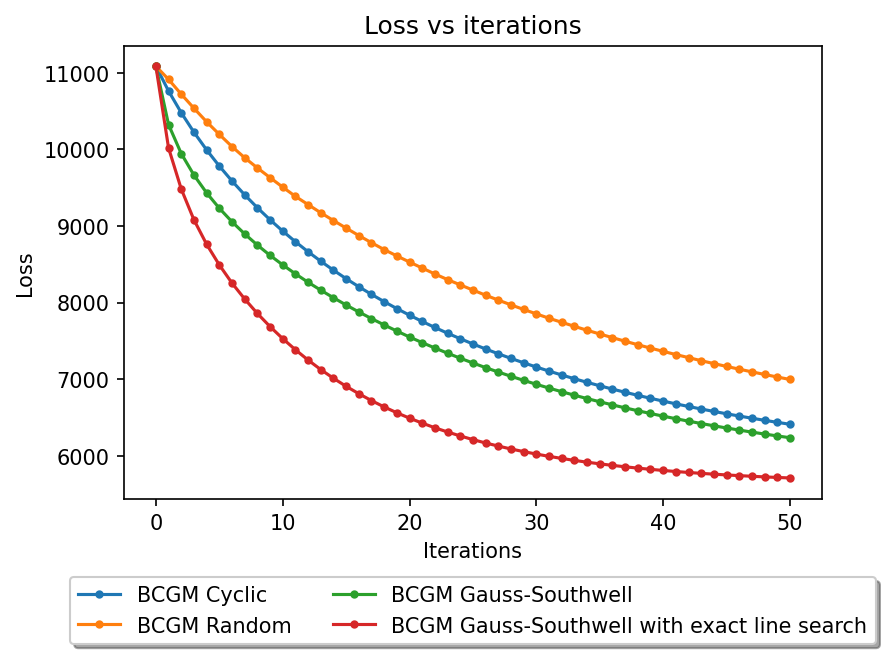

In [235]:
pl.figure(dpi=PLOT_DPI)
pl.plot(losses_bcgm_cyclic, marker='.')
pl.plot(losses_bcgm_random, marker='.')
pl.plot(losses_bcgm_gs, marker='.')
pl.plot(losses_bcgm_gs_exact, marker='.')

pl.title("Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauss-Southwell with exact line search'
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

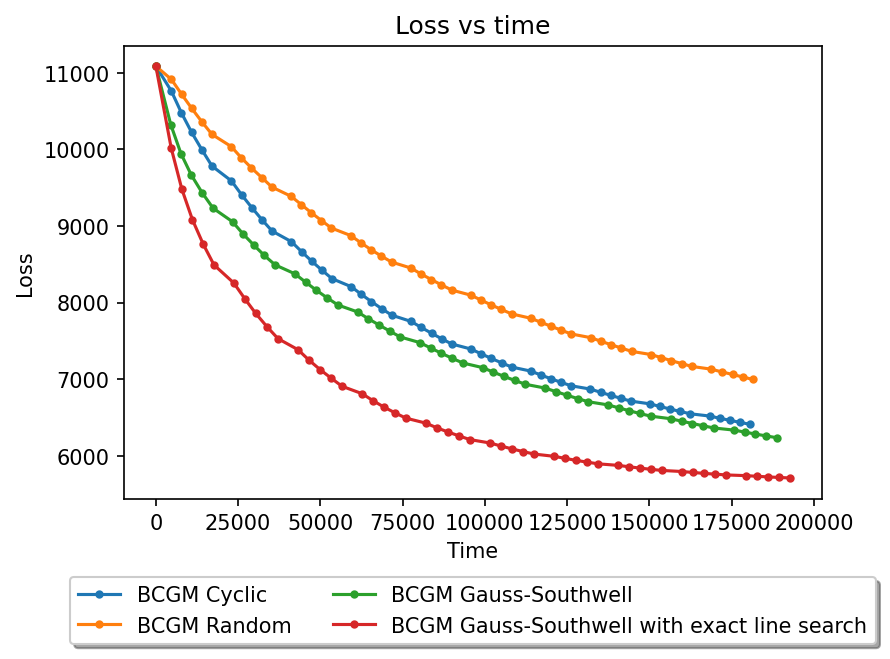

In [236]:
pl.figure(dpi=PLOT_DPI)
pl.plot(ticks_bcgd_cyclic, losses_bcgm_cyclic, marker='.')
pl.plot(ticks_bcgd_random, losses_bcgm_random, marker='.')
pl.plot(ticks_bcgd_gs, losses_bcgm_gs, marker='.')
pl.plot(ticks_bcgd_gs_exact, losses_bcgm_gs_exact, marker='.')

pl.title("Loss vs time")
pl.xlabel("Time")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'BCGM Gauss-Southwell with exact line search'
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

### Only Gradient Descent Compared

In [237]:
min_acc = np.min(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
min_y_plot = min_acc - .1 * (1 - min_acc)
max_y_plot = max_acc + (.1 * (1 - max_acc))

#### Accuracy

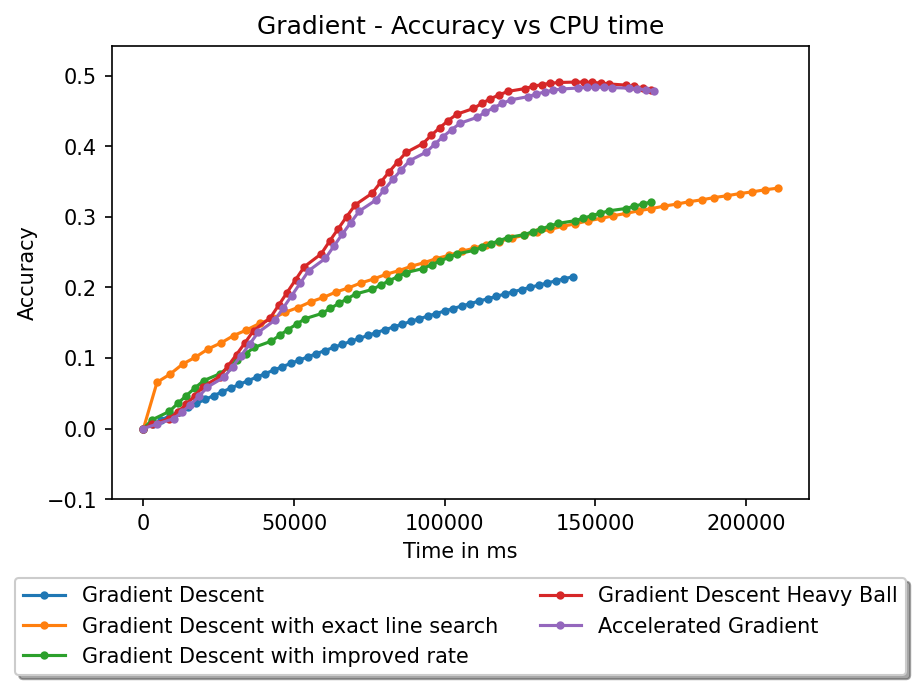

In [238]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.plot(ticks_gd_exact, accuracies_gd_exact, marker='.')
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

pl.title("Gradient - Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    ['Gradient Descent',
     'Gradient Descent with exact line search',
     'Gradient Descent with improved rate',
     'Gradient Descent Heavy Ball',
     "Accelerated Gradient"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

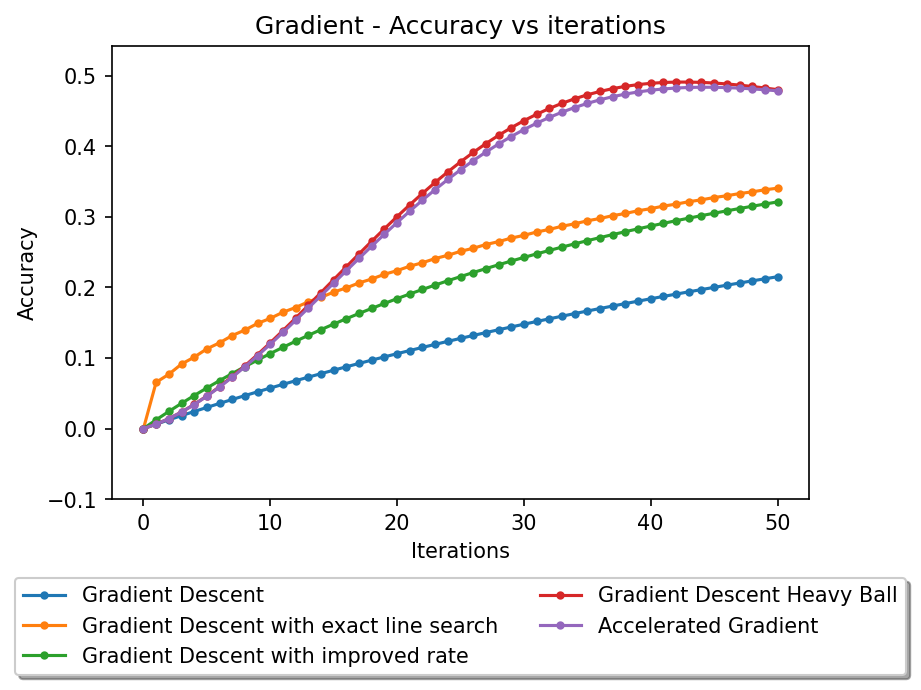

In [239]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_gd, marker='.')
pl.plot(accuracies_gd_exact, marker='.')
pl.plot(accuracies_gd_improved, marker='.')
pl.plot(accuracies_gd_hb, marker='.')
pl.plot(accuracies_gd_accelerated, marker='.')

pl.title("Gradient - Accuracy vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Accuracy")

pl.legend(
    ['Gradient Descent',
     'Gradient Descent with exact line search',
     'Gradient Descent with improved rate',
     'Gradient Descent Heavy Ball',
     "Accelerated Gradient"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

#### Loss

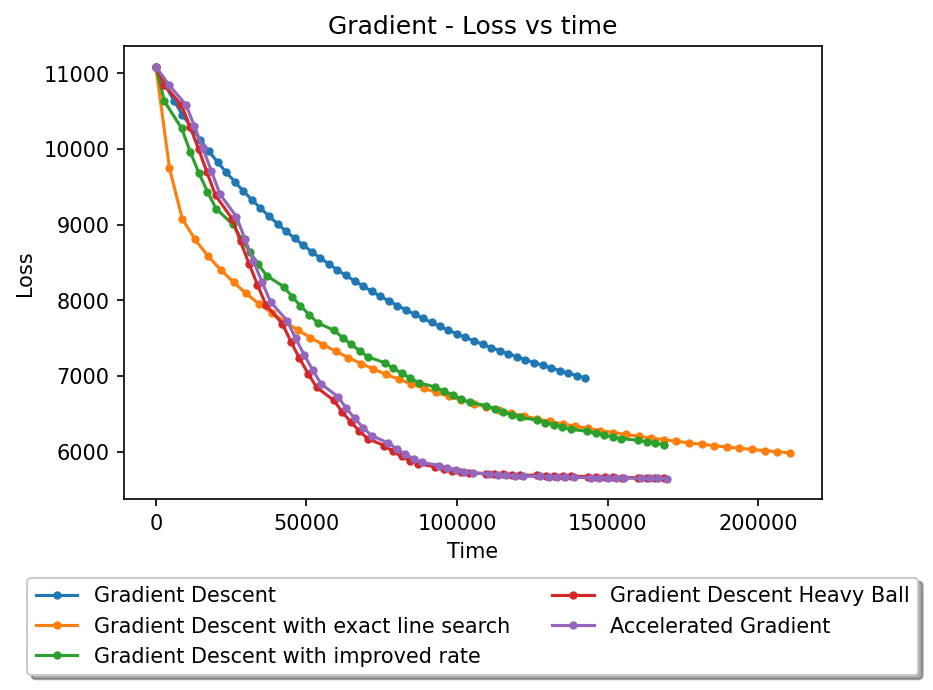

In [240]:
pl.figure(dpi=PLOT_DPI)
pl.plot(ticks_gd, losses_gd, marker='.')
pl.plot(ticks_gd_exact, losses_gd_exact, marker='.')
pl.plot(ticks_gd_improved, losses_gd_improved, marker='.')
pl.plot(ticks_gd_hb, losses_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated, losses_gd_accelerated, marker='.')

pl.title("Gradient - Loss vs time")
pl.xlabel("Time")
pl.ylabel("Loss")
pl.legend(
    [
        'Gradient Descent',
        'Gradient Descent with exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

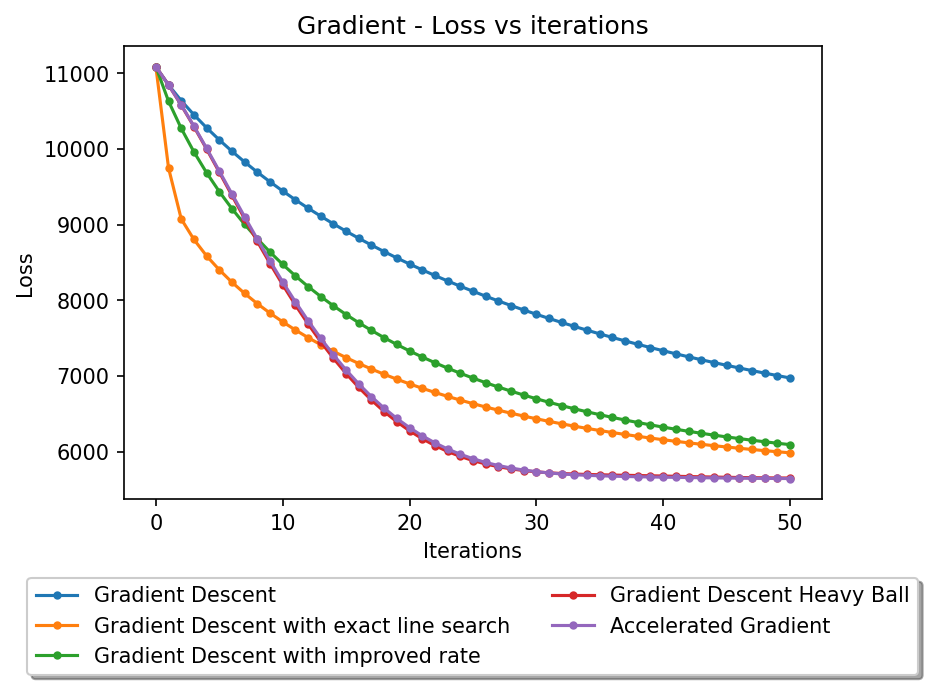

In [241]:
pl.figure(dpi=PLOT_DPI)
pl.plot(losses_gd, marker='.')
pl.plot(losses_gd_exact, marker='.')
pl.plot(losses_gd_improved, marker='.')
pl.plot(losses_gd_hb, marker='.')
pl.plot(losses_gd_accelerated, marker='.')

pl.title("Gradient - Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'Gradient Descent',
        'Gradient Descent with exact line search',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

## GIF

Following are the scripts used to generate the GIFs from the frames created

In [242]:
if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
    paths =[
        "./gif/gd_binary",
        "./gif/gd_exact_binary",
        "./gif/gd_improved_binary",
        "./gif/gd_hb_binary",
        "./gif/gd_accelerated_binary",
        "./gif/bcgd_random_binary",
        "./gif/bcgd_cyclic_binary",
        "./gif/bcgd_gs_binary",
        "./gif/bcgd_gs_exact_binary"
    ]
    for i, path in enumerate(paths):
        filenames = sorted([f"{path}/{name}" for name in next(walk(path), (None, None, []))[2]])
        if filenames:
            print(f"creating gif {i+1}/{len(paths)}")
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave(f'{path}.gif', images, duration=30/len(images))
    print("Done")

In [243]:
if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
    paths =[
        "./gif/gd",
        "./gif/gd_exact",
        "./gif/gd_improved",
        "./gif/gd_hb",
        "./gif/gd_accelerated",
        "./gif/bcgd_random",
        "./gif/bcgd_cyclic",
        "./gif/bcgd_gs",
        "./gif/bcgd_gs_exact"
    ]
    for i, path in enumerate(paths):
        filenames = sorted([f"{path}/{name}" for name in next(walk(path), (None, None, []))[2]])
        if filenames:
            print(f"creating gif {i+1}/{len(paths)}")
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave(f'{path}.gif', images, duration=30/len(images))
    print("Done")

In [244]:
if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2):
    paths =[
        "./gif/loss_gd",
        "./gif/loss_gd_exact",
        "./gif/loss_gd_improved",
        "./gif/loss_gd_hb",
        "./gif/loss_gd_accelerated",
        "./gif/loss_bcgd_random",
        "./gif/loss_bcgd_cyclic",
        "./gif/loss_bcgd_gs",
        "./gif/loss_bcgd_gs_exact",
    ]
    for i, path in enumerate(paths):
        filenames = sorted([f"{path}/{name}" for name in next(walk(path), (None, None, []))[2]])
        if filenames:
            print(f"creating gif {i+1}/{len(paths)}")
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave(f'{path}.gif', images, duration=30/len(images))
    print("Done")

## Other plots for the report

This section contains code that are not meaningful to the notebook, but needed to generate some plots of the report

In [245]:
if False:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Final result")
    final_y_unlabeled = (y_unlabeled_gd_accelerated/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])
    pl.legend(["Class 1", "Class -1"])

In [246]:

if False:
    ticks_bcgd_cyclic_old, accuracies_bcgd_cyclic_old, losses_bcgm_cyclic_old = np.copy(ticks_bcgd_cyclic), np.copy(accuracies_bcgd_cyclic), np.copy(losses_bcgm_cyclic)
    ticks_bcgd_random_old, accuracies_bcgd_random_old, losses_bcgm_random_old = np.copy(ticks_bcgd_random), np.copy(accuracies_bcgd_random), np.copy(losses_bcgm_random)
    ticks_bcgd_gs_old, accuracies_bcgd_gs_old, losses_bcgm_gs_old = np.copy(ticks_bcgd_gs), np.copy(accuracies_bcgd_gs), np.copy(losses_bcgm_gs)

In [247]:
if False:
    pl.title("BCGM Cyclic accuracy")
    pl.plot(accuracies_bcgd_cyclic_old, marker='.')
    pl.plot(accuracies_bcgd_cyclic, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()
    pl.title("BCGM Random accuracy")
    pl.plot(accuracies_bcgd_random_old, marker='.')
    pl.plot(accuracies_bcgd_random, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()
    pl.title("BCGM Gauss Southwell accuracy")
    pl.plot(accuracies_bcgd_gs_old, marker='.')
    pl.plot(accuracies_bcgd_gs, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()

In [248]:
if False:
    pl.title("BCGM Cyclic loss")
    pl.plot(losses_bcgm_cyclic_old, marker='.')
    pl.plot(losses_bcgm_cyclic, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()
    pl.title("BCGM Random loss")
    pl.plot(losses_bcgm_random_old, marker='.')
    pl.plot(losses_bcgm_random, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()
    pl.title("BCGM Gauss Southwell loss")
    pl.plot(losses_bcgm_gs_old, marker='.')
    pl.plot(losses_bcgm_gs, marker='.')
    pl.legend(["Optimized", "Not optimized"])
    pl.show()

In [249]:
if False:
    pl.figure(dpi=PLOT_DPI)
    pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
    pl.ylim(min_y_plot, max_y_plot)
    pl.plot(accuracies_bcgd_cyclic_old, marker='.')
    pl.plot(accuracies_bcgd_random_old, marker='.')
    pl.plot(accuracies_bcgd_gs_old, marker='.')
    pl.plot(accuracies_gd, marker='.')
    pl.plot(accuracies_gd_improved, marker='.')
    pl.plot(accuracies_gd_hb, marker='.')
    pl.plot(accuracies_gd_accelerated, marker='.')

    pl.title("Accuracy vs iterations (optimized)")
    pl.xlabel("Iterations")
    pl.ylabel("Accuracy")
    pl.legend(
        [
            'BCGM Cyclic',
            'BCGM Random',
            'BCGM Gauss-Southwell',
            'Gradient Descent',
            'Gradient Descent with improved rate',
            'Gradient Descent Heavy Ball',
            "Accelerated Gradient"
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True, shadow=True, ncol=2
    )

In [250]:
if False:
    pl.figure(dpi=PLOT_DPI)
    pl.plot(losses_bcgm_cyclic_old, marker='.')
    pl.plot(losses_bcgm_random_old, marker='.')
    pl.plot(losses_bcgm_gs_old, marker='.')
    pl.plot(losses_gd, marker='.')
    pl.plot(losses_gd_improved, marker='.')
    pl.plot(losses_gd_hb, marker='.')
    pl.plot(losses_gd_accelerated, marker='.')

    pl.title("Loss vs iterations (optimized)")
    pl.xlabel("Iterations")
    pl.ylabel("Loss")
    pl.legend(
        [
            'BCGM Cyclic',
            'BCGM Random',
            'BCGM Gauss-Southwell',
            'Gradient Descent',
            'Gradient Descent with improved rate',
            'Gradient Descent Heavy Ball',
            "Accelerated Gradient"
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True, shadow=True, ncol=2
    )

In [251]:
if False:

    accuracies_bcgd_random_normal, losses_bcgm_random_normal = \
        np.copy(accuracies_bcgd_random), np.copy(losses_bcgm_random)

In [252]:
if False:
    pl.figure(dpi=PLOT_DPI)
    pl.plot(accuracies_bcgd_random_normal)
    pl.plot(accuracies_bcgd_random_old)
    pl.plot(accuracies_bcgd_random)
    pl.legend(["BCGM random using L and uniform sampling", "BCGM random using Li and uniform sampling", "BCGM random using L and Li-based sampling"])